## 1. Loading the data

In [39]:
from dataset import SubjectTrialDataset_SingleElectrode
from subject_braintreebank import BrainTreebankSubject
from subject_ajile12 import AjileSubject
import torch
from model_model import BFModule
from model_transformers import Transformer
import torch.nn as nn
from train_utils import log
import random

AJILE = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
log(f'Using device: {device}')
dtype = torch.float32

subject_id, trial_id = (3, 4) if AJILE else (3, 1) # changed from 3, 0
window_size = 512 if AJILE else 2048
subject = AjileSubject(subject_id, cache=True) if AJILE else BrainTreebankSubject(subject_id, cache=True)
electrode_subset = ["10GRID"] if AJILE else [ 'O1aIb1',
 'O1aIb2',
 'O1aIb3',
 'O1aIb4',
 'O1aIb5',
 'O1aIb6',
 'O1aIb7',
 'O1aIb8',
 'O1aIb9',
 'O1aIb10',
 'O1aIb11',
 'O1aIb12',
 'O1aIb13',
 'O1aIb14',
 'O1aIb15',
 'O1aIb16',]
electrode_subset = ['T1cIe1',
 'T1cIe2',
 'T1cIe5',
 'T1cIe6',
 'T1cIe7',
 'T1cIe8',
 'T1cIe9',
 'T1cIe10',
 'T1cIe11',
 'T1cIe12',]
# [ 'F3d1',
#  'F3d2',
#  'F3d3',
#  'F3d4',
#  'F3d5',
#  'F3d6',
#  'F3d7',
#  'F3d8',
#  'F3d9',
#  'F3d10',]
electrode_subset = subject.electrode_labels
eval_electrode_index = 0 if AJILE else electrode_subset.index('T1cIe11')
subject.set_electrode_subset(electrode_subset)
dataset = SubjectTrialDataset_SingleElectrode(subject, trial_id, window_size=window_size, dtype=dtype, unsqueeze_electrode_dimension=False, electrodes_subset=electrode_subset)
log("Data shape: " + str(dataset[0]['data'].shape))

[20:05:23 gpu 18.6G ram 38.6G] (0) Using device: cuda


[20:06:26 gpu 18.6G ram 48.6G] (0) Data shape: torch.Size([2048])


In [40]:
len(dataset)

1311052

## 2. Defining the modules
### Distribution Inverter

In [41]:
class DistributionInverter(BFModule):
    def __init__(self, samples, eps=1e-5):
        super().__init__()
        self.samples = samples
        self.mean = nn.Parameter(samples.mean(dim=0).view(1, 1, -1))
        self.std = nn.Parameter(samples.std(dim=0).view(1, 1, -1))
        self.eps = eps

    def forward(self, x):
        # x is of shape (batch_size, seq_len, n_channels)
        # samples is of shape (n_samples, n_channels)
        return (x - self.mean) / (self.std + self.eps)
        # return torch.sum(self.samples.unsqueeze(0).unsqueeze(0) <= x.unsqueeze(-1), dim=-1) / len(self.samples)

In [42]:
# Create samples from 10 random indices of the dataset
samples = torch.cat([dataset[random.randint(0, len(dataset)-1)]['data'].flatten() for _ in range(100)])
inverter = DistributionInverter(samples=samples).to(device, dtype=dtype)

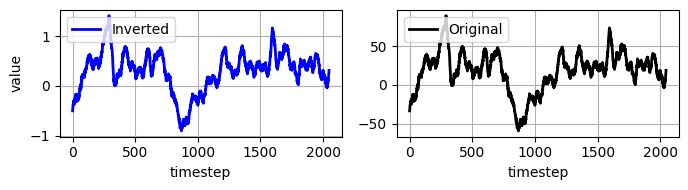

In [43]:
import matplotlib.pyplot as plt

# Get the data
example_idx = 1000
inverted_data = inverter(dataset[example_idx]['data'].unsqueeze(0).to(device, dtype=dtype)).detach().cpu().float().numpy().flatten()
original_data = dataset[example_idx]['data'].unsqueeze(0).detach().cpu().float().numpy().flatten()

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2))

# Plot inverted data on first axis
ax1.plot(inverted_data, color='blue', linewidth=2, label='Inverted')
ax1.set_xlabel('timestep')
ax1.set_ylabel('value') 
ax1.grid(True)
ax1.legend(loc='upper left')

# Plot original data on second axis
ax2.plot(original_data, color='k', linewidth=2, label='Original')
ax2.set_xlabel('timestep')
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Masker

In [44]:
class Masker(BFModule):
    def __init__(self, p_masked_intervals, interval_length=1):
        super().__init__()
        self.p_masked_intervals = p_masked_intervals
        self.interval_length = interval_length
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, channels)
        batch_size, seq_len, channels = x.shape
        
        # Initialize mask tensor with all True values
        mask = torch.zeros((seq_len, channels), dtype=torch.bool, device=x.device)
        masked_x = x.clone()

        n_total_intervals = seq_len * channels
        n_masked_intervals = int(n_total_intervals * self.p_masked_intervals)

        # Create a flattened list of all possible (time, channel) indices
        all_indices = [(t, c) for t in range(seq_len-self.interval_length) for c in range(channels)]
        # Randomly select indices to mask
        masked_indices = random.sample(all_indices, n_masked_intervals)
        # Create the mask and apply it to x
        for t, c in masked_indices:
            # For each selected index, mask an interval of length self.interval_length
            mask[t:t+self.interval_length, c] = True
            masked_x[..., t:t+self.interval_length, c] = 0.0  # Replace with zeros
        
        return masked_x, mask

class NoneMasker(BFModule):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x, None


### FFTaker

In [45]:
class FFTaker(BFModule):
    def __init__(self, n_fft, hop_length):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        
    def forward(self, x):
        # x is of shape (batch_size, seq_len, n_channels)
        # output is of shape (batch_size, n_fft//2 + 1, n_channels)
        return torch.stft(x, n_fft=self.n_fft, hop_length=self.hop_length, return_complex=True)
        

### Embedder

In [75]:
class EmbedderInterpolation(BFModule):
    def __init__(self, d_model, resolution=10, range=(-3, 3)):
        super().__init__()
        self.d_model = d_model
        self.resolution = resolution
        self.range = range
        self.delta = (range[1] - range[0]) / (resolution-1)

        self.embedding_centers = torch.linspace(range[0], range[1], resolution)
        self.embedding_weights = torch.nn.Parameter(torch.randn(resolution, d_model) / d_model)
        
    def forward(self, x):
        # x is of shape (batch_size, seq_len, n_channels, d_input)
        # output is of shape (batch_size, seq_len, n_channels, d_model)
        batch_size, seq_len, n_channels, d_input = x.shape
        assert d_input == 1, "d_input must be 1, EmbedderInterpolation only supports single input channel"
        x = x.squeeze(-1)

        output = torch.zeros(*x.shape, self.d_model, device=x.device, dtype=x.dtype)
        for center_i, embedding_center in enumerate(self.embedding_centers):
            distance_multiplier = torch.maximum(1 - torch.abs(x - embedding_center) / self.delta, torch.tensor(0))
            output += distance_multiplier.unsqueeze(-1) * self.embedding_weights[center_i].view(1, 1, 1, -1)
        output[x<self.range[0]] = self.embedding_weights[0]
        output[x>self.range[1]] = self.embedding_weights[-1]
        return output

# class EmbedderDiscretized(BFModule):
#     def __init__(self, d_model, resolution=10, range=(-3, 3)):
#         super().__init__()
#         self.d_model = d_model
#         self.resolution = resolution
#         self.range = range
        
#     def forward(self, x):
#         # x is of shape (batch_size, seq_len, n_channels)
#         # output is of shape (batch_size, seq_len, n_channels, d_model)
#         output = torch.zeros(*x.shape, self.d_model, device=x.device, dtype=x.dtype)
#         for center_i, embedding_center in enumerate(self.embedding_centers):
#             distance_multiplier = torch.maximum(1 - torch.abs(x - embedding_center) / self.delta, torch.tensor(0))
#             output += distance_multiplier.unsqueeze(-1) * self.embedding_weights[center_i].view(1, 1, 1, -1)

class EmbedderLinear(BFModule):
    def __init__(self, d_model, d_input):
        super().__init__()
        self.d_model = d_model
        self.d_input = d_input
        self.linear_embedding = nn.Linear(d_input, d_model)

    def forward(self, x):
        return self.linear_embedding(x)

from hilbert_decode import hilbert_decode
class EmbedderHilbert(BFModule):
    def __init__(self, d_model, d_hilbert=4, d_input=1, resolution=6, range=None):
        super().__init__()
        self.d_model = d_model
        self.d_hilbert = d_hilbert
        self.d_input = d_input
        self.linear_projection = nn.Linear(d_hilbert, d_model)
        self.bits_per_dimension = resolution
    def forward(self, x):
        # x is of shape (batch_size, seq_len, n_channels, d_input)
        # output is of shape (batch_size, seq_len, n_channels, d_model)
        batch_size, seq_len, n_channels, d_input = x.shape
        assert d_input == 1, "d_input must be 1, EmbedderHilbert only supports single input channel"
        x = x.squeeze(-1)

        # x_device, x_dtype = x.device, x.dtype
        # x = hilbert_decode(x.detach().cpu().float().numpy(), self.d_hilbert, self.bits_per_dimension)
        # x = torch.tensor(x, device=x_device, dtype=x_dtype)

        max_h = 2**(self.d_hilbert*self.bits_per_dimension)
        x = hilbert_decode(x, self.d_hilbert, self.bits_per_dimension).to(x.device, x.dtype) / max_h**0.5
        return self.linear_projection(x)
        
Embedder = EmbedderLinear

class EmbedderNull():
    def __init__(self, d_model, resolution=10, range=(-3, 3)):
        self.__call__ = self.forward
        self.d_model = d_model
        pass
        
    def forward(self, x):
        # x is of shape (batch_size, seq_len, n_channels, d_input)
        # output is of shape (batch_size, seq_len, n_channels, d_model)
        batch_size, seq_len, n_channels, d_input = x.shape
        output = torch.zeros(*x.shape[:-1], self.d_model, device=x.device, dtype=x.dtype)
        output[:, :, :, :d_input] = x
        return output

    def __call__(self, x):
        return self.forward(x)


In [76]:
class Model(BFModule):
    def __init__():
        pass
    
class ContrastiveModel(Model):
    def __init__(self, d_model=128, n_layers=4, n_heads=8, d_input=1):
        super(Model, self).__init__()
        self.d_input = d_input
        self.d_model = d_model
        self.n_layers = n_layers
        self.n_heads = n_heads
        # self.transformer = Transformer(d_input=d_model, d_model=d_model, d_output=d_model, 
        #                                 n_layer=n_layers, n_head=n_heads, causal=True, 
        #                                 rope=True, cls_token=False, rope_base=window_size*2 // d_input)
        self.embed = EmbedderNull(d_model=d_model)
        self.unembed = EmbedderNull(d_model=d_model)
        # self.embed = EmbedderLinear(d_model=d_model, d_input=d_input)
        # self.unembed = EmbedderLinear(d_model=d_model, d_input=d_input)
        self.mask_token = nn.Parameter(torch.zeros(d_model))

        self.transformer = self._null_transformer

    def _null_transformer(self, x, positions=None):
        return x
    
    def forward(self, x, y=None, mask=None):
        # x is of shape (batch_size, seq_len, n_channels, d_input) 
        # y is of shape (batch_size, seq_len, n_channels, d_input)
        batch_size, seq_len, n_channels, d_input = x.shape

        x = self.embed(x)# shape (batch_size, seq_len, n_channels, d_model)
        if mask is not None:
            x[:, mask, :] = self.mask_token.view(1, 1, 1, -1)
        
        positions = torch.arange(seq_len).repeat(1, n_channels).flatten().to(self.device)
        x = self.transformer(x.reshape(batch_size, seq_len*n_channels, self.d_model), positions=positions) # shape (batch_size, seq_len, d_model)
        x = x.reshape(batch_size, seq_len, n_channels, self.d_model)

        if y is not None:
            y = self.unembed(y) # shape (batch_size, seq_len, n_channels, d_model)
            return x, y
        return x
        
    def calculate_loss(self, batch, mask=None):
        # batch is of shape (batch_size, seq_len, n_channels, d_input)
        if mask is not None:
            x, y = self(batch, batch, mask=mask) # shape (batch_size, seq_len, n_channels, d_model)
        else:
            x, y = self(batch[:, :-1], batch[:, 1:]) # shape (batch_size, seq_len, n_channels, d_model)
        batch_size = batch.shape[0]

        if mask is not None:
            x = x[:, mask, :]
            y = y[:, mask, :]
        else:
            batch_size, seq_len, n_channels, d_model = x.shape
            x = x.reshape(batch_size, seq_len*n_channels, d_model)
            y = y.reshape(batch_size, seq_len*n_channels, d_model)
        # x shape: (batch_size, num_masked_intervals or seq_len*n_channels, d_model)
        # y shape: (batch_size, num_masked_intervals or seq_len*n_channels, d_model)

        similarity = torch.matmul(x[:, :].permute(1, 0, 2), y[:, :].permute(1, 2, 0))
        expanded_arange = torch.arange(batch_size).unsqueeze(0).repeat(x.shape[1], 1).to(device, dtype=torch.long).reshape(-1)
        loss = torch.nn.functional.cross_entropy(similarity.view(-1, batch_size), expanded_arange)
        return loss

In [77]:
n_steps = 10000
batch_size = 128
import itertools
dataloader = iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True))
dataloader = iter(itertools.cycle(dataloader))

n_samples_per_bin = 1
model = ContrastiveModel(d_input=n_samples_per_bin).to(device, dtype=dtype)
inverter = DistributionInverter(samples=samples).to(device, dtype=dtype)
masker = NoneMasker()
#masker = Masker(p_masked_intervals=0.5).to(device, dtype=dtype)

In [17]:
batch = next(dataloader)
batch_data = batch['data'].to(device, dtype=dtype).reshape(batch_size, window_size//n_samples_per_bin, n_samples_per_bin) # shape (batch_size, seq_len, 1)
batch_data = inverter(batch_data)

## 3. Evaluation class

In [78]:
import sklearn
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
import numpy as np

from btbench.btbench_train_test_splits import generate_splits_SS_SM
class ModelEvaluation_BTBench():
    def __init__(self, model, inverter, subject_trials, eval_names, batch_size=128, dtype=torch.float32, feature_aggregation_method='mean', mean_collapse_factor=1, start_neural_data_before_word_onset=0, end_neural_data_after_word_onset=2048, eval_electrode_index=eval_electrode_index):
        self.model = model
        self.inverter = inverter
        self.subject_trials = subject_trials
        self.eval_names = eval_names
        self.batch_size = batch_size
        self.dtype = dtype
        self.feature_aggregation_method = feature_aggregation_method
        self.mean_collapse_factor = mean_collapse_factor
        self.start_neural_data_before_word_onset = start_neural_data_before_word_onset
        self.end_neural_data_after_word_onset = end_neural_data_after_word_onset
        self.eval_electrode_index = eval_electrode_index
        
        # Create evaluation datasets
        self.evaluation_datasets = {}
        for eval_name in self.eval_names:
            for subject, trial_id in self.subject_trials:
                splits = generate_splits_SS_SM(subject, trial_id, eval_name, dtype=self.dtype,
                                               start_neural_data_before_word_onset=self.start_neural_data_before_word_onset,
                                               end_neural_data_after_word_onset=self.end_neural_data_after_word_onset)
                self.evaluation_datasets[(eval_name, subject.subject_identifier, trial_id)] = splits

    def evaluate_on_dataset(self, train_dataset, test_dataset):
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)
        test_dataloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)
        
        device = next(self.model.parameters()).device
        
        # Get embeddings for train and test data
        X_train, y_train = [], []
        for batch_input, batch_label in train_dataloader:
            batch_input = batch_input.to(device, dtype=self.dtype)
            batch_size = batch_input.shape[0]
            window_size = batch_input.shape[2]

            batch_input = batch_input[:, self.eval_electrode_index] # select just the first channel

            batch_data = batch_input.to(device, dtype=dtype).reshape(batch_size, window_size//n_samples_per_bin, 1, n_samples_per_bin) # shape (batch_size, seq_len, 1)
            batch_data = self.inverter(batch_data)

            with torch.no_grad():
                x_embed = self.model(batch_data)
            
            batch_size, seq_len, _, d_model = x_embed.shape
            x_embed = x_embed.reshape(batch_size, seq_len//self.mean_collapse_factor, self.mean_collapse_factor, d_model)
            x_embed = x_embed.mean(dim=2)

            if self.feature_aggregation_method == 'mean':
                X_train.append(x_embed.mean(dim=1).cpu().float().numpy())  # Average across sequence length
            elif self.feature_aggregation_method == 'concat':
                X_train.append(x_embed.reshape(batch_size, -1).cpu().float().numpy())  # Concatenate across sequence length
            y_train.append(batch_label.numpy())        
        X_test, y_test = [], []
        for batch_input, batch_label in test_dataloader:
            batch_input = batch_input.to(device, dtype=self.dtype)
            batch_size = batch_input.shape[0]
            window_size = batch_input.shape[2]

            batch_input = batch_input[:, self.eval_electrode_index] # select just the first channel

            batch_data = batch_input.to(device, dtype=dtype).reshape(batch_size, window_size//n_samples_per_bin, 1, n_samples_per_bin) # shape (batch_size, seq_len, 1)
            batch_data = self.inverter(batch_data)

            with torch.no_grad():
                x_embed = self.model(batch_data)
            batch_size, seq_len, _, d_model = x_embed.shape
            x_embed = x_embed.reshape(batch_size, seq_len//self.mean_collapse_factor, self.mean_collapse_factor, d_model)
            x_embed = x_embed.mean(dim=2)

            if self.feature_aggregation_method == 'mean':
                X_test.append(x_embed.mean(dim=1).cpu().float().numpy())
            elif self.feature_aggregation_method == 'concat':
                X_test.append(x_embed.reshape(batch_size, -1).cpu().float().numpy())
            y_test.append(batch_label.numpy())

        X_train = np.concatenate(X_train)
        y_train = np.concatenate(y_train)
        X_test = np.concatenate(X_test)
        y_test = np.concatenate(y_test)

        # Train logistic regression classifier
        clf = LogisticRegression(random_state=42, max_iter=10000)
        clf.fit(X_train, y_train)

        # Get predictions and calculate metrics
        test_probs = clf.predict_proba(X_test)
        accuracy = clf.score(X_test, y_test)
        
        # Calculate AUROC
        y_test_onehot = np.zeros((len(y_test), len(clf.classes_)))
        for i, label in enumerate(y_test):
            class_idx = np.where(clf.classes_ == label)[0][0]
            y_test_onehot[i, class_idx] = 1
            
        if len(clf.classes_) > 2:
            auroc = sklearn.metrics.roc_auc_score(y_test_onehot, test_probs, multi_class='ovr', average='macro')
        else:
            auroc = sklearn.metrics.roc_auc_score(y_test_onehot, test_probs)
            
        return auroc, accuracy

    def evaluate(self, return_raw=False):
        results = {}
        for subject in set(subject for subject, _ in self.subject_trials):
            for eval_name in self.eval_names:
                trial_ids = [trial_id for _subject, trial_id in self.subject_trials if _subject == subject]
                for trial_id in trial_ids:
                    splits = self.evaluation_datasets[(eval_name, subject.subject_identifier, trial_id)]
                    auroc_list, acc_list = [], []
                    for train_dataset, test_dataset in zip(splits[0], splits[1]):
                        auroc, acc = self.evaluate_on_dataset(train_dataset, test_dataset)
                        auroc_list.append(auroc)
                        acc_list.append(acc)
                    
                    mean_auroc = np.mean(auroc_list)
                    mean_acc = np.mean(acc_list)
                    results[(eval_name, subject.subject_identifier, trial_id)] = (mean_auroc, mean_acc) if not return_raw else (auroc_list, acc_list)
                    
        return self._format_results(results) if not return_raw else results
        
    def _format_results(self, results):
        formatted_results = {}
        for eval_name in self.eval_names:
            auroc_values = []
            acc_values = []
            subject_aurocs = {}
            subject_accs = {}
            
            for (metric, subject_id, trial_id) in [k for k in results.keys() if k[0] == eval_name]:
                if subject_id not in subject_aurocs:
                    subject_aurocs[subject_id] = []
                    subject_accs[subject_id] = []
                    
                auroc, acc = results[(eval_name, subject_id, trial_id)]
                subject_aurocs[subject_id].append(auroc)
                subject_accs[subject_id].append(acc)
                
                formatted_results[f"eval_auroc/{subject_id}_{trial_id}_{eval_name}"] = auroc
                formatted_results[f"eval_acc/{subject_id}_{trial_id}_{eval_name}"] = acc
                
            for subject_id in subject_aurocs:
                auroc_values.append(np.mean(subject_aurocs[subject_id]))
                acc_values.append(np.mean(subject_accs[subject_id]))
                
            if auroc_values:
                formatted_results[f"eval_auroc/average_{eval_name}"] = np.mean(auroc_values)
                formatted_results[f"eval_acc/average_{eval_name}"] = np.mean(acc_values)
                
        return formatted_results

import ajilebench.ajilebench_train_test_splits
class ModelEvaluation_AjileBench():
    def __init__(self, model, inverter, subject_trials, eval_names, batch_size=128, dtype=torch.float32, feature_aggregation_method='mean', mean_collapse_factor=1):
        self.model = model
        self.inverter = inverter
        self.subject_trials = subject_trials
        self.eval_names = eval_names
        self.batch_size = batch_size
        self.dtype = dtype
        self.feature_aggregation_method = feature_aggregation_method
        self.mean_collapse_factor = mean_collapse_factor
        
        # Create evaluation datasets
        self.evaluation_datasets = {}
        for eval_name in self.eval_names:
            for subject, trial_id in self.subject_trials:
                splits = ajilebench.ajilebench_train_test_splits.generate_splits_SS_SM(subject, trial_id, eval_name, dtype=self.dtype,
                                                                                        start_neural_data_before_reach_onset=0,
                                                                                        end_neural_data_after_reach_onset=512)
                self.evaluation_datasets[(eval_name, subject.subject_identifier, trial_id)] = splits

    def evaluate_on_dataset(self, train_dataset, test_dataset):
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        
        device = next(self.model.parameters()).device
        
        # Get embeddings for train and test data
        X_train, y_train = [], []
        for batch_input, batch_label in train_dataloader:
            batch_input = batch_input.to(device, dtype=self.dtype)
            batch_size = batch_input.shape[0]
            window_size = batch_input.shape[2]
            batch_data = batch_input.to(device, dtype=dtype).reshape(batch_size, window_size//n_samples_per_bin, 1, n_samples_per_bin) # shape (batch_size, seq_len, 1, *)
            batch_data = self.inverter(batch_data)

            with torch.no_grad():
                x_embed = self.model(batch_data)
            
            batch_size, seq_len, _, d_model = x_embed.shape
            x_embed = x_embed.reshape(batch_size, seq_len//self.mean_collapse_factor, self.mean_collapse_factor, d_model)
            x_embed = x_embed.mean(dim=2)

            if self.feature_aggregation_method == 'mean':
                X_train.append(x_embed.mean(dim=1).cpu().float().numpy())  # Average across sequence length
            elif self.feature_aggregation_method == 'concat':
                X_train.append(x_embed.reshape(batch_size, -1).cpu().float().numpy())  # Concatenate across sequence length
            y_train.append(batch_label.numpy())        
        X_test, y_test = [], []
        for batch_input, batch_label in test_dataloader:
            batch_input = batch_input.to(device, dtype=self.dtype)
            batch_size = batch_input.shape[0]
            window_size = batch_input.shape[2]
            batch_data = batch_input.to(device, dtype=dtype).reshape(batch_size, window_size//n_samples_per_bin, 1, n_samples_per_bin) # shape (batch_size, seq_len, 1)
            batch_data = self.inverter(batch_data)

            with torch.no_grad():
                x_embed = self.model(batch_data)
            batch_size, seq_len, _, d_model = x_embed.shape
            x_embed = x_embed.reshape(batch_size, seq_len//self.mean_collapse_factor, self.mean_collapse_factor, d_model)
            x_embed = x_embed.mean(dim=2)

            if self.feature_aggregation_method == 'mean':
                X_test.append(x_embed.mean(dim=1).cpu().float().numpy())
            elif self.feature_aggregation_method == 'concat':
                X_test.append(x_embed.reshape(batch_size, -1).cpu().float().numpy())
            y_test.append(batch_label.numpy())

        X_train = np.concatenate(X_train)
        y_train = np.concatenate(y_train)
        X_test = np.concatenate(X_test)
        y_test = np.concatenate(y_test)

        # Train logistic regression classifier
        clf = LogisticRegression(random_state=42, max_iter=10000)
        clf.fit(X_train, y_train)

        # Get predictions and calculate metrics
        test_probs = clf.predict_proba(X_test)
        accuracy = clf.score(X_test, y_test)
        
        # Calculate AUROC
        y_test_onehot = np.zeros((len(y_test), len(clf.classes_)))
        for i, label in enumerate(y_test):
            class_idx = np.where(clf.classes_ == label)[0][0]
            y_test_onehot[i, class_idx] = 1
            
        if len(clf.classes_) > 2:
            auroc = sklearn.metrics.roc_auc_score(y_test_onehot, test_probs, multi_class='ovr', average='macro')
        else:
            auroc = sklearn.metrics.roc_auc_score(y_test_onehot, test_probs)
            
        return auroc, accuracy

    def evaluate(self, return_raw=False):
        results = {}
        for subject in set(subject for subject, _ in self.subject_trials):
            for eval_name in self.eval_names:
                trial_ids = [trial_id for _subject, trial_id in self.subject_trials if _subject == subject]
                for trial_id in trial_ids:
                    splits = self.evaluation_datasets[(eval_name, subject.subject_identifier, trial_id)]
                    auroc_list, acc_list = [], []
                    for train_dataset, test_dataset in zip(splits[0], splits[1]):
                        auroc, acc = self.evaluate_on_dataset(train_dataset, test_dataset)
                        auroc_list.append(auroc)
                        acc_list.append(acc)
                    
                    mean_auroc = np.mean(auroc_list)
                    mean_acc = np.mean(acc_list)
                    results[(eval_name, subject.subject_identifier, trial_id)] = (mean_auroc, mean_acc) if not return_raw else (auroc_list, acc_list)
                    
        return self._format_results(results) if not return_raw else results
        
    def _format_results(self, results):
        formatted_results = {}
        for eval_name in self.eval_names:
            auroc_values = []
            acc_values = []
            subject_aurocs = {}
            subject_accs = {}
            
            for (metric, subject_id, trial_id) in [k for k in results.keys() if k[0] == eval_name]:
                if subject_id not in subject_aurocs:
                    subject_aurocs[subject_id] = []
                    subject_accs[subject_id] = []
                    
                auroc, acc = results[(eval_name, subject_id, trial_id)]
                subject_aurocs[subject_id].append(auroc)
                subject_accs[subject_id].append(acc)
                
                formatted_results[f"eval_auroc/{subject_id}_{trial_id}_{eval_name}"] = auroc
                formatted_results[f"eval_acc/{subject_id}_{trial_id}_{eval_name}"] = acc
                
            for subject_id in subject_aurocs:
                auroc_values.append(np.mean(subject_aurocs[subject_id]))
                acc_values.append(np.mean(subject_accs[subject_id]))
                
            if auroc_values:
                formatted_results[f"eval_auroc/average_{eval_name}"] = np.mean(auroc_values)
                formatted_results[f"eval_acc/average_{eval_name}"] = np.mean(acc_values)
                
        return formatted_results

In [79]:
if AJILE:
    evaluation = ModelEvaluation_AjileBench(model, inverter, [(subject, trial_id)], ["reach_onset"], feature_aggregation_method='concat', mean_collapse_factor=32)
else:
    evaluation = ModelEvaluation_BTBench(model, inverter, [(subject, 0)], ["gpt2_surprisal"], feature_aggregation_method='concat', mean_collapse_factor=128)
evaluation.evaluate()

{'eval_auroc/btbank3_0_gpt2_surprisal': 0.6167960883423826,
 'eval_acc/btbank3_0_gpt2_surprisal': 0.5837890625,
 'eval_auroc/average_gpt2_surprisal': 0.6167960883423826,
 'eval_acc/average_gpt2_surprisal': 0.5837890625}

In [86]:
class ModelEvaluation_BTBenchNull():
    def __init__(self, model, inverter, subject_trials, eval_names, batch_size=128, dtype=torch.float32, feature_aggregation_method='mean', mean_collapse_factor=1, start_neural_data_before_word_onset=0, end_neural_data_after_word_onset=2048, eval_electrode_index=eval_electrode_index):
        self.model = model
        self.inverter = inverter
        self.subject_trials = subject_trials
        self.eval_names = eval_names
        self.batch_size = batch_size
        self.dtype = dtype
        self.feature_aggregation_method = feature_aggregation_method
        self.mean_collapse_factor = mean_collapse_factor
        self.start_neural_data_before_word_onset = start_neural_data_before_word_onset
        self.end_neural_data_after_word_onset = end_neural_data_after_word_onset
        self.eval_electrode_index = eval_electrode_index
        
        # Create evaluation datasets
        self.evaluation_datasets = {}
        for eval_name in self.eval_names:
            for subject, trial_id in self.subject_trials:
                splits = generate_splits_SS_SM(subject, trial_id, eval_name, dtype=self.dtype,
                                               start_neural_data_before_word_onset=self.start_neural_data_before_word_onset,
                                               end_neural_data_after_word_onset=self.end_neural_data_after_word_onset)
                self.evaluation_datasets[(eval_name, subject.subject_identifier, trial_id)] = splits

    def evaluate_on_dataset(self, train_dataset, test_dataset):
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)
        test_dataloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)
        
        device = next(self.model.parameters()).device
        
        # Get embeddings for train and test data
        X_train, y_train = [], []
        for batch_input, batch_label in train_dataloader:
            batch_input = batch_input.to(device, dtype=self.dtype)
            batch_size = batch_input.shape[0]
            window_size = batch_input.shape[2]

            batch_input = batch_input[:, self.eval_electrode_index] # select just the first channel

            batch_data = batch_input.to(device, dtype=dtype).reshape(batch_size, window_size//n_samples_per_bin, 1, n_samples_per_bin) # shape (batch_size, seq_len, 1)
            batch_data = self.inverter(batch_data)
            
            x_embed = batch_data.detach()
            
            batch_size, seq_len, _, d_model = x_embed.shape
            x_embed = x_embed.reshape(batch_size, seq_len//self.mean_collapse_factor, self.mean_collapse_factor, d_model)
            x_embed = x_embed.mean(dim=2)

            if self.feature_aggregation_method == 'mean':
                X_train.append(x_embed.mean(dim=1).cpu().float().numpy())  # Average across sequence length
            elif self.feature_aggregation_method == 'concat':
                X_train.append(x_embed.reshape(batch_size, -1).cpu().float().numpy())  # Concatenate across sequence length
            y_train.append(batch_label.numpy())        
        X_test, y_test = [], []
        for batch_input, batch_label in test_dataloader:
            batch_input = batch_input.to(device, dtype=self.dtype)
            batch_size = batch_input.shape[0]
            window_size = batch_input.shape[2]

            batch_input = batch_input[:, self.eval_electrode_index] # select just the first channel

            batch_data = batch_input.to(device, dtype=dtype).reshape(batch_size, window_size//n_samples_per_bin, 1, n_samples_per_bin) # shape (batch_size, seq_len, 1)
            batch_data = self.inverter(batch_data)

            x_embed = batch_data.detach()

            batch_size, seq_len, _, d_model = x_embed.shape
            x_embed = x_embed.reshape(batch_size, seq_len//self.mean_collapse_factor, self.mean_collapse_factor, d_model)
            x_embed = x_embed.mean(dim=2)

            if self.feature_aggregation_method == 'mean':
                X_test.append(x_embed.mean(dim=1).cpu().float().numpy())
            elif self.feature_aggregation_method == 'concat':
                X_test.append(x_embed.reshape(batch_size, -1).cpu().float().numpy())
            y_test.append(batch_label.numpy())

        X_train = np.concatenate(X_train)
        y_train = np.concatenate(y_train)
        X_test = np.concatenate(X_test)
        y_test = np.concatenate(y_test)

        # Train logistic regression classifier
        clf = LogisticRegression(random_state=42, max_iter=10000)
        clf.fit(X_train, y_train)

        # Get predictions and calculate metrics
        test_probs = clf.predict_proba(X_test)
        accuracy = clf.score(X_test, y_test)
        
        # Calculate AUROC
        y_test_onehot = np.zeros((len(y_test), len(clf.classes_)))
        for i, label in enumerate(y_test):
            class_idx = np.where(clf.classes_ == label)[0][0]
            y_test_onehot[i, class_idx] = 1
            
        if len(clf.classes_) > 2:
            auroc = sklearn.metrics.roc_auc_score(y_test_onehot, test_probs, multi_class='ovr', average='macro')
        else:
            auroc = sklearn.metrics.roc_auc_score(y_test_onehot, test_probs)
            
        return auroc, accuracy

    def evaluate(self, return_raw=False):
        results = {}
        for subject in set(subject for subject, _ in self.subject_trials):
            for eval_name in self.eval_names:
                trial_ids = [trial_id for _subject, trial_id in self.subject_trials if _subject == subject]
                for trial_id in trial_ids:
                    splits = self.evaluation_datasets[(eval_name, subject.subject_identifier, trial_id)]
                    auroc_list, acc_list = [], []
                    for train_dataset, test_dataset in zip(splits[0], splits[1]):
                        auroc, acc = self.evaluate_on_dataset(train_dataset, test_dataset)
                        auroc_list.append(auroc)
                        acc_list.append(acc)
                    
                    mean_auroc = np.mean(auroc_list)
                    mean_acc = np.mean(acc_list)
                    results[(eval_name, subject.subject_identifier, trial_id)] = (mean_auroc, mean_acc) if not return_raw else (auroc_list, acc_list)
                    
        return self._format_results(results) if not return_raw else results
        
    def _format_results(self, results):
        formatted_results = {}
        for eval_name in self.eval_names:
            auroc_values = []
            acc_values = []
            subject_aurocs = {}
            subject_accs = {}
            
            for (metric, subject_id, trial_id) in [k for k in results.keys() if k[0] == eval_name]:
                if subject_id not in subject_aurocs:
                    subject_aurocs[subject_id] = []
                    subject_accs[subject_id] = []
                    
                auroc, acc = results[(eval_name, subject_id, trial_id)]
                subject_aurocs[subject_id].append(auroc)
                subject_accs[subject_id].append(acc)
                
                formatted_results[f"eval_auroc/{subject_id}_{trial_id}_{eval_name}"] = auroc
                formatted_results[f"eval_acc/{subject_id}_{trial_id}_{eval_name}"] = acc
                
            for subject_id in subject_aurocs:
                auroc_values.append(np.mean(subject_aurocs[subject_id]))
                acc_values.append(np.mean(subject_accs[subject_id]))
                
            if auroc_values:
                formatted_results[f"eval_auroc/average_{eval_name}"] = np.mean(auroc_values)
                formatted_results[f"eval_acc/average_{eval_name}"] = np.mean(acc_values)
                
        return formatted_results
    
evaluation = ModelEvaluation_BTBenchNull(model, inverter, [(subject, 0)], ["gpt2_surprisal"], feature_aggregation_method='concat', mean_collapse_factor=1)
evaluation.evaluate()
    

{'eval_auroc/btbank3_0_gpt2_surprisal': 0.5645543950373539,
 'eval_acc/btbank3_0_gpt2_surprisal': 0.5412109375,
 'eval_auroc/average_gpt2_surprisal': 0.5645543950373539,
 'eval_acc/average_gpt2_surprisal': 0.5412109375}

## 4. Training the model

In [24]:
initial_lr = 0.003
use_muon = True
optimizers = []
schedulers = []
if use_muon:
    from muon import Muon
    all_params = list(model.parameters())
    matrix_params = [p for p in all_params if p.ndim >= 2]
    other_params = [p for p in all_params if p.ndim < 2]
    optimizers.append(Muon(matrix_params, lr=initial_lr, momentum=0.95, nesterov=True, backend='newtonschulz5', backend_steps=5))
    if len(other_params) > 0:
        optimizers.append(torch.optim.AdamW(other_params, lr=initial_lr, betas=(0.9, 0.95)))
    #schedulers.append(None)  # Muon doesn't support schedulers
    #schedulers.append(torch.optim.lr_scheduler.LinearLR(optimizers[1], start_factor=1.0, end_factor=0.0, total_iters=n_steps))
else:
    optimizers = [torch.optim.AdamW(model.parameters(), lr=initial_lr, betas=(0.9, 0.95))]
    #schedulers = [torch.optim.lr_scheduler.LinearLR(optimizers[0], start_factor=1.0, end_factor=0.0, total_iters=n_steps)]

training_logs = []
step = 1
for batch in dataloader:
    for optimizer in optimizers:
        optimizer.zero_grad()

    batch_data = batch['data'].to(device, dtype=dtype).reshape(batch_size, window_size//n_samples_per_bin, n_samples_per_bin) # shape (batch_size, seq_len, 1)
    batch_data = inverter(batch_data)
    masked_x, mask = masker.forward(batch_data)

    loss = model.calculate_loss(masked_x.unsqueeze(-2), mask=mask)
    loss.backward()
    for optimizer in optimizers:
        optimizer.step()
    
    # Step the schedulers
    for scheduler in schedulers:
        if scheduler is not None:
            scheduler.step()
    
    # Log metrics
    log_dict = {
        'train_loss': loss.item(),
    }
    
    if step % 100 == 0:
        current_lr = optimizers[-1].param_groups[0]['lr']
        print(f"Step {step}, Loss: {loss.item():.4f}, LR: {current_lr:.6f}")
        
        # Add evaluation results
        evaluation_results = evaluation.evaluate()
        log_dict.update(evaluation_results)
        print(log_dict)
        
    training_logs.append(log_dict)
        
    if step == n_steps:
        break # Only process one batch per step
    step += 1


Step 100, Loss: 4.7551, LR: 0.003000
{'train_loss': 4.755141258239746, 'eval_auroc/btbank3_0_gpt2_surprisal': 0.6191908103550015, 'eval_acc/btbank3_0_gpt2_surprisal': 0.587890625, 'eval_auroc/average_gpt2_surprisal': 0.6191908103550015, 'eval_acc/average_gpt2_surprisal': 0.587890625}
Step 200, Loss: 4.5826, LR: 0.003000
{'train_loss': 4.58257532119751, 'eval_auroc/btbank3_0_gpt2_surprisal': 0.6201206926708942, 'eval_acc/btbank3_0_gpt2_surprisal': 0.58515625, 'eval_auroc/average_gpt2_surprisal': 0.6201206926708942, 'eval_acc/average_gpt2_surprisal': 0.58515625}
Step 300, Loss: 4.4784, LR: 0.003000
{'train_loss': 4.478390216827393, 'eval_auroc/btbank3_0_gpt2_surprisal': 0.6286543417596838, 'eval_acc/btbank3_0_gpt2_surprisal': 0.59140625, 'eval_auroc/average_gpt2_surprisal': 0.6286543417596838, 'eval_acc/average_gpt2_surprisal': 0.59140625}
Step 400, Loss: 4.4219, LR: 0.003000
{'train_loss': 4.421937465667725, 'eval_auroc/btbank3_0_gpt2_surprisal': 0.6277752646987086, 'eval_acc/btbank3_0_

KeyboardInterrupt: 

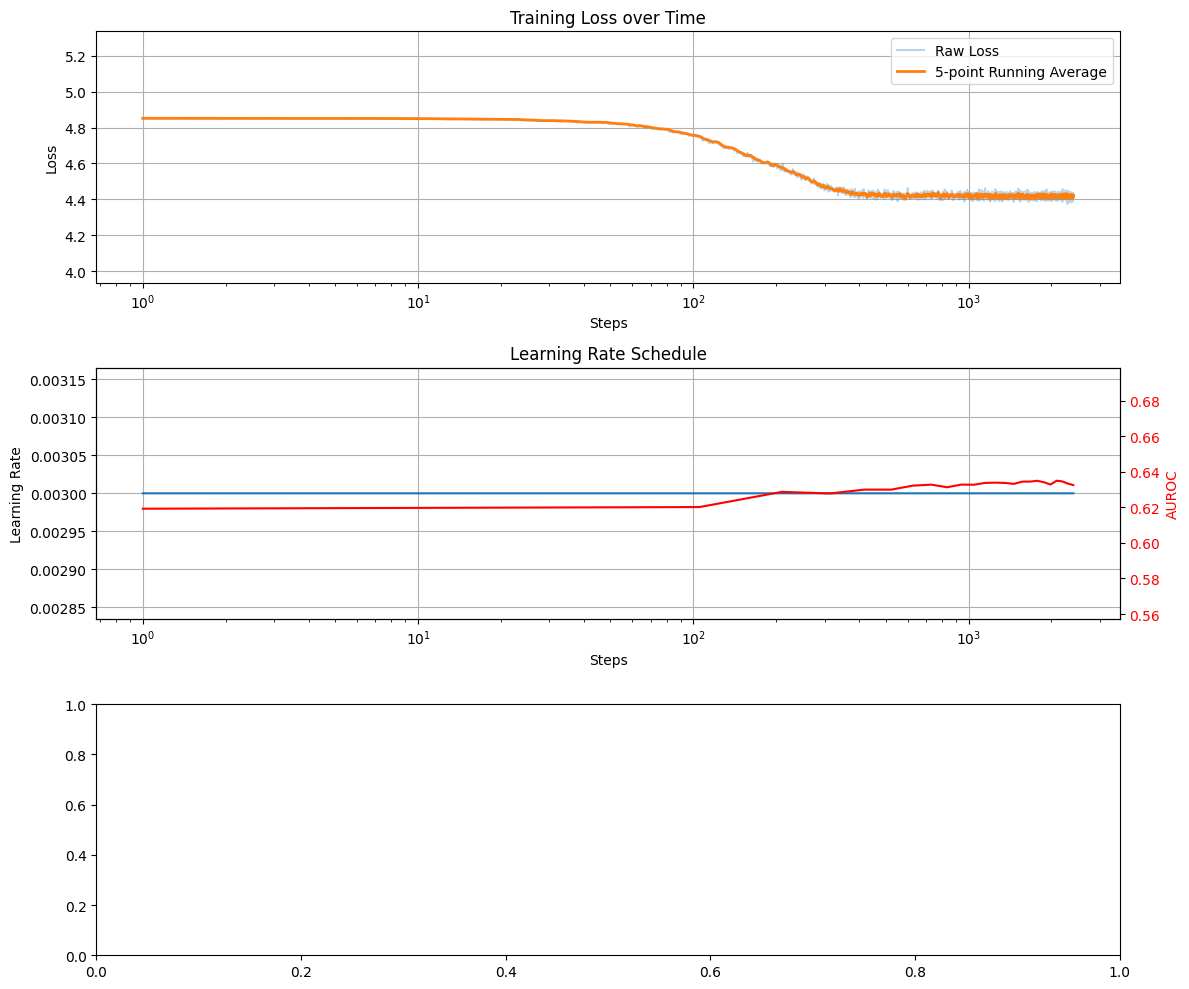

In [25]:
# Extract values from training logs
steps = []
losses = []
lrs = []
stds = []
aurocs = []
accs = []

# Parse the training logs list of dicts
step = 1
for log_dict in training_logs:
    steps.append(step)
    losses.append(log_dict['train_loss'])
    # Extract evaluation metrics if available
    if 'eval_auroc/average_reach_onset' in log_dict:
        aurocs.append(log_dict['eval_auroc/average_reach_onset'])
        accs.append(log_dict['eval_acc/average_reach_onset'])
    # Extract evaluation metrics if available
    if 'eval_auroc/average_onset' in log_dict:
        aurocs.append(log_dict['eval_auroc/average_onset'])
        accs.append(log_dict['eval_acc/average_onset'])
    # Extract evaluation metrics if available
    if 'eval_auroc/average_gpt2_surprisal' in log_dict:
        aurocs.append(log_dict['eval_auroc/average_gpt2_surprisal'])
        accs.append(log_dict['eval_acc/average_gpt2_surprisal'])
    
    # Get learning rate from last optimizer
    current_lr = optimizers[-1].param_groups[0]['lr']
    lrs.append(current_lr)
    step += 1

# Calculate running average of losses
n_ave = 5
running_avg_losses = []
for i in range(len(losses)):
    if i < n_ave - 1:
        # For first n_ave-1 points, average what we have
        running_avg_losses.append(sum(losses[:i+1]) / (i+1))
    else:
        # For remaining points, take n_ave point average
        running_avg_losses.append(sum(losses[i-n_ave+1:i+1]) / n_ave)

# Create figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# Plot loss with running average
ax1.semilogx(steps, losses, alpha=0.3, label='Raw Loss')
ax1.semilogx(steps, running_avg_losses, linewidth=2, label=f'{n_ave}-point Running Average')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss over Time')
ax1.grid(True)
ax1.set_ylim(min(losses)*0.9, max(losses)*1.1)
ax1.legend()

# Plot learning rate
ax2.semilogx(steps, lrs)
ax2.set_xlabel('Steps') 
ax2.set_ylabel('Learning Rate')
ax2.set_title('Learning Rate Schedule')
ax2.grid(True)

# If we have evaluation metrics, add them to the plot
if aurocs:
    # Create a twin axis for the AUROC values
    ax4 = ax2.twinx()
    eval_steps = np.linspace(1, len(steps), len(aurocs))  # Only use steps where we have eval metrics
    ax4.semilogx(eval_steps, aurocs, 'r-', label='AUROC')
    ax4.set_ylabel('AUROC', color='r')
    ax4.tick_params(axis='y', labelcolor='r')
    ax4.set_ylim(min(aurocs)*0.9, max(aurocs)*1.1)  # Adjust based on your data

plt.tight_layout()
plt.show()


In [16]:
eval_names = ["gpt2_surprisal"]
verbose = True

bins_start_before_word_onset_seconds = 0.5
bins_end_after_word_onset_seconds = 1.0 # 2.5
bin_size_seconds = 0.125

import time

for eval_name in eval_names:
    results_electrode = {}
    for electrode_idx, electrode_label in enumerate(electrode_subset):
        if verbose:
            print(f"Electrode {electrode_label} subject loaded")

        results_electrode[electrode_label] = {
            "time_bins": [],
        }


        # Loop over all time bins
        bin_starts = np.arange(-bins_start_before_word_onset_seconds, bins_end_after_word_onset_seconds, bin_size_seconds)
        bin_ends = bin_starts + bin_size_seconds
        # Add a time bin for the whole window
        # bin_starts = np.append(bin_starts, -bins_start_before_word_onset_seconds)
        # bin_ends = np.append(bin_ends, bins_end_after_word_onset_seconds)
        # # Add a time bin for 1 second after the word onset
        # bin_starts = np.append(bin_starts, 0)
        # bin_ends = np.append(bin_ends, 1)

        for bin_start, bin_end in zip(bin_starts, bin_ends):
            data_idx_from = int((-bin_start)*subject.get_sampling_rate())
            data_idx_to = int((bin_end)*subject.get_sampling_rate())

            bin_results = {
                "time_bin_start": float(bin_start),
                "time_bin_end": float(bin_end),
                "folds": []
            }

            eval_trial_id = trial_id
            evaluation = ModelEvaluation_BTBench(model, inverter, [(subject, eval_trial_id)], eval_names, feature_aggregation_method='concat', 
                                        mean_collapse_factor=32//n_samples_per_bin, 
                                        start_neural_data_before_word_onset=data_idx_from, 
                                        end_neural_data_after_word_onset=data_idx_to, 
                                        eval_electrode_index=electrode_idx)
            eval_results = evaluation.evaluate(return_raw=True)[(eval_name, subject.subject_identifier, eval_trial_id)]
            auroc_list, acc_list = eval_results
            for auroc, acc in zip(auroc_list, acc_list):
                bin_results["folds"].append({
                    "test_accuracy": float(acc),
                    "test_roc_auc": float(auroc)
                })
            
            if verbose: print(f"Electrode {electrode_label} ({electrode_idx+1}/{len(electrode_subset)}), Bin {bin_start}-{bin_end}: Test accuracy: {acc_list}, Test ROC AUC: {auroc_list}")

            if bin_start == -bins_start_before_word_onset_seconds and bin_end == bins_end_after_word_onset_seconds:
                results_electrode[electrode_label]["whole_window"] = bin_results # whole window results
            elif bin_start == 0 and bin_end == 1:
                results_electrode[electrode_label]["one_second_after_onset"] = bin_results # one second after onset results
            else:
                results_electrode[electrode_label]["time_bins"].append(bin_results) # time bin results

    results = {
        "model_name": "Logistic Regression",
        "author": None,
        "description": "Simple linear regression.",
        "organization": "MIT",
        "organization_url": "https://mit.edu",
        "timestamp": time.time(),

        "evaluation_results": {
            f"{subject.subject_identifier}_{trial_id}": {
                "electrode": results_electrode
            }
        },

        "random_seed": 42
    }

    import os, json
    save_dir = "eval_results"
    os.makedirs(save_dir, exist_ok=True) # Create save directory if it doesn't exist
    with open(f"{save_dir}/single_electrode_model_{subject.subject_identifier}_{trial_id}_{eval_name}_gpt_T2.json", "w") as f:
        json.dump(results, f, indent=4)
    if verbose:
        print(f"Results saved to {save_dir}/single_electrode_model_{subject.subject_identifier}_{trial_id}_{eval_name}_gpt_T2.json")

Electrode T1cIe1 subject loaded


Electrode T1cIe1 (1/10), Bin -0.5--0.375: Test accuracy: [0.4734375, 0.503125, 0.509375, 0.5015625, 0.4890625], Test ROC AUC: [0.4807150405072209, 0.4991871590719903, 0.5173389742535084, 0.5034533625102575, 0.4900072674418605]
Electrode T1cIe1 (1/10), Bin -0.375--0.25: Test accuracy: [0.5140625, 0.5, 0.4859375, 0.5265625, 0.4953125], Test ROC AUC: [0.5279832491878987, 0.5228183055694293, 0.5055087111084995, 0.5085821187136103, 0.49296334852294155]
Electrode T1cIe1 (1/10), Bin -0.25--0.125: Test accuracy: [0.4984375, 0.509375, 0.4765625, 0.5015625, 0.503125], Test ROC AUC: [0.5098821963915307, 0.5332089588780837, 0.5061354800168445, 0.5261859638154038, 0.49753987272155875]
Electrode T1cIe1 (1/10), Bin -0.125-0.0: Test accuracy: [0.53125, 0.4640625, 0.4796875, 0.490625, 0.4765625], Test ROC AUC: [0.5419259520175336, 0.47726983380830657, 0.5024434194161256, 0.5014018600289164, 0.4821112900691389]
Electrode T1cIe1 (1/10), Bin 0.0-0.125: Test accuracy: [0.4875, 0.51875, 0.471875, 0.4921875,

In [112]:
import random

vocab_size = 10000
vocab = []
for i in range(vocab_size // (window_size // n_samples_per_bin)):
    vocab.append(dataset[random.randint(0, len(dataset)-1)]['data'].reshape(window_size//n_samples_per_bin, n_samples_per_bin))
    vocab[-1] /= 100
vocab = torch.cat(vocab, dim=0)
vocab = vocab.to(device)
vocab_size = len(vocab)
print(vocab.shape)

torch.Size([9920, 4])


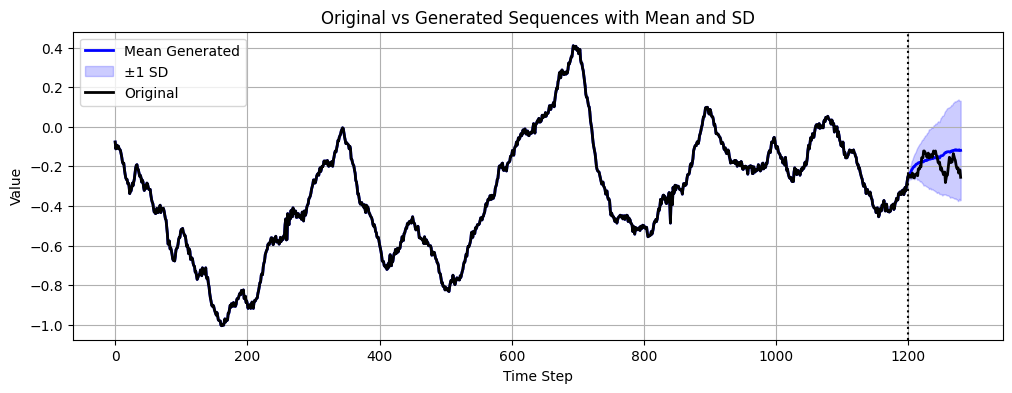

In [116]:
generate_steps = 20
n_generations = 100
batch_index = random.randint(0, len(dataset)-1)

example_seq = dataset[batch_index]['data'].reshape(window_size//n_samples_per_bin, n_samples_per_bin).unsqueeze(0).to(device)
example_seq = example_seq.expand(n_generations, -1, -1)
example_seq = example_seq / 100
continued_seq = model.generate_continuation(example_seq[:, :example_seq.shape[1]-generate_steps], generate_steps, vocab)

example_seq = example_seq[0,:].detach().cpu().numpy().flatten()

import matplotlib.pyplot as plt
import numpy as np

# Plot original and continued sequences
plt.figure(figsize=(12,4))

# Convert continued sequences to numpy array for statistics
continued_seqs_np = np.array([seq.detach().cpu().numpy().flatten() for seq in continued_seq])
mean_seq = np.mean(continued_seqs_np, axis=0)
std_seq = np.std(continued_seqs_np, axis=0)

# Plot individual continued sequences
# for i in range(n_generations):
#     continued_seq_item = continued_seqs_np[i]
#     plt.plot(continued_seq_item, '--', label='Generated' if i == 0 else None, alpha=0.2, color='red', linewidth=1)

# Plot mean and standard deviation
plt.plot(mean_seq, '-', color='blue', label='Mean Generated', linewidth=2)
plt.fill_between(range(len(mean_seq)), mean_seq-std_seq, mean_seq+std_seq, color='blue', alpha=0.2, label='±1 SD')
    
# Plot original sequence
plt.plot(example_seq, label='Original', alpha=1.0, color='k', linewidth=2)

# Add vertical line where generation starts
plt.axvline(x=example_seq.shape[0]-generate_steps*n_samples_per_bin, color='k', linestyle=':')

plt.legend()
plt.title('Original vs Generated Sequences with Mean and SD')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()


In [ ]:
from dataset import SubjectTrialDataset_SingleElectrode
from subject_braintreebank import BrainTreebankSubject
from subject_ajile12 import AjileSubject
import torch
from model_model import BFModule
from model_transformers import Transformer
import torch.nn as nn
from train_utils import log
import random, os



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
log(f'Using device: {device}')
dtype = torch.float32

subject_id, trial_id = (3, 1) # changed from 3, 0
window_size = 2048
subject = BrainTreebankSubject(subject_id, cache=True)

log(f'Subject: {subject.subject_identifier}, Trial: {trial_id}, loading data...')
electrode_subset = subject.electrode_labels
eval_electrode_index = electrode_subset.index('T1cIe11')
subject.set_electrode_subset(electrode_subset)
dataset = SubjectTrialDataset_SingleElectrode(subject, trial_id, window_size=window_size, dtype=dtype, unsqueeze_electrode_dimension=False, electrodes_subset=electrode_subset)
log("Data shape: " + str(dataset[0]['data'].shape))


In [13]:

n_samples_per_bin = 1
n_samples_inverter = 100
mean_collapse_factor = 128//n_samples_per_bin

# Set default values for model parameters
d_hilbert = 4
d_embed = 128
bits_per_sample = 3
n_steps = 3000
batch_size = 128

save_dir = f'eval_results/single_electrode_new/'
os.makedirs(save_dir, exist_ok=True)

filename = f'{subject.subject_identifier}_{trial_id}_embed{d_embed}_hilbert{d_hilbert}_bits{bits_per_sample}.json'


class DistributionInverter(BFModule):
    def __init__(self, samples, eps=1e-5):
        super().__init__()
        self.samples = samples
        self.mean = nn.Parameter(samples.mean(dim=0).view(1, 1, -1))
        self.std = nn.Parameter(samples.std(dim=0).view(1, 1, -1))
        self.eps = eps

    def forward(self, x):
        # x is of shape (batch_size, seq_len, n_channels)
        # samples is of shape (n_samples, n_channels)
        return (x - self.mean) / (self.std + self.eps)
        # return torch.sum(self.samples.unsqueeze(0).unsqueeze(0) <= x.unsqueeze(-1), dim=-1) / len(self.samples)

class EmbedderInterpolation(BFModule):
    def __init__(self, d_model, resolution=10, range=(-3, 3)):
        super().__init__()
        self.d_model = d_model
        self.resolution = resolution
        self.range = range
        self.delta = (range[1] - range[0]) / (resolution-1)

        self.embedding_centers = torch.linspace(range[0], range[1], resolution)
        self.embedding_weights = torch.nn.Parameter(torch.randn(resolution, d_model) / d_model)
        
    def forward(self, x):
        # x is of shape (batch_size, seq_len, n_channels, d_input)
        # output is of shape (batch_size, seq_len, n_channels, d_model)
        batch_size, seq_len, n_channels, d_input = x.shape
        assert d_input == 1, "d_input must be 1, EmbedderInterpolation only supports single input channel"
        x = x.squeeze(-1)

        output = torch.zeros(*x.shape, self.d_model, device=x.device, dtype=x.dtype)
        for center_i, embedding_center in enumerate(self.embedding_centers):
            distance_multiplier = torch.maximum(1 - torch.abs(x - embedding_center) / self.delta, torch.tensor(0))
            output += distance_multiplier.unsqueeze(-1) * self.embedding_weights[center_i].view(1, 1, 1, -1)
        output[x<self.range[0]] = self.embedding_weights[0]
        output[x>self.range[1]] = self.embedding_weights[-1]
        return output

class EmbedderLinear(BFModule):
    def __init__(self, d_model, d_input):
        super().__init__()
        self.d_model = d_model
        self.d_input = d_input
        self.linear_embedding = nn.Linear(d_input, d_model)

    def forward(self, x):
        return self.linear_embedding(x)

from hilbert_decode import hilbert_decode
class EmbedderHilbert(BFModule):
    def __init__(self, d_model, d_hilbert=4, d_input=1, resolution=3, range=(-3, 3)):
        super().__init__()
        self.d_model = d_model
        self.d_hilbert = d_hilbert
        self.d_input = d_input
        self.linear_projection = nn.Linear(d_hilbert, d_model) if d_model > 0 else lambda x: x
        self.bits_per_dimension = resolution
        self.range = range

    def forward(self, x):
        # x is of shape (batch_size, seq_len, n_channels, d_input)
        # output is of shape (batch_size, seq_len, n_channels, d_model)
        batch_size, seq_len, n_channels, d_input = x.shape
        assert d_input == 1, "d_input must be 1, EmbedderHilbert only supports single input channel"
        x = x.squeeze(-1)

        # Clamp to range first, then normalize to [0, 1]
        x = torch.clamp(x, self.range[0], self.range[1])
        x = (x - self.range[0]) / (self.range[1] - self.range[0])

        max_h = 2**(self.d_hilbert*self.bits_per_dimension)
        x = hilbert_decode(x, self.d_hilbert, self.bits_per_dimension).to(x.device, x.dtype) / max_h**0.5
        return self.linear_projection(x)

class Model(BFModule):
    def __init__():
        pass

class ContrastiveModel(Model):
    def __init__(self, d_model=128, n_layers=4, n_heads=8, d_input=1):
        super(Model, self).__init__()
        self.d_input = d_input
        self.d_model = d_model
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.transformer = Transformer(d_input=d_model, d_model=d_model, d_output=d_model, 
                                        n_layer=n_layers, n_head=n_heads, causal=True, 
                                        rope=True, cls_token=False, rope_base=window_size*2 // d_input)
        self.embed = EmbedderHilbert(d_model=d_model, d_hilbert=d_hilbert, d_input=d_input, resolution=bits_per_sample)
        self.unembed = EmbedderHilbert(d_model=d_model, d_hilbert=d_hilbert, d_input=d_input, resolution=bits_per_sample)

        self.mask_token = nn.Parameter(torch.zeros(d_model))
    
    def forward(self, x, y=None, mask=None):
        # x is of shape (batch_size, seq_len, n_channels, d_input) 
        # y is of shape (batch_size, seq_len, n_channels, d_input)
        batch_size, seq_len, n_channels, d_input = x.shape

        x = self.embed(x)# shape (batch_size, seq_len, n_channels, d_model)
        if mask is not None:
            x[:, mask, :] = self.mask_token.view(1, 1, 1, -1)
        
        positions = torch.arange(seq_len).repeat(1, n_channels).flatten().to(self.device)
        x = self.transformer(x.reshape(batch_size, seq_len*n_channels, self.d_model), positions=positions) # shape (batch_size, seq_len, d_model)
        x = x.reshape(batch_size, seq_len, n_channels, self.d_model)

        if y is not None:
            y = self.unembed(y) # shape (batch_size, seq_len, n_channels, d_model)
            return x, y
        return x
        
    def calculate_loss(self, batch, mask=None):
        # batch is of shape (batch_size, seq_len, n_channels, d_input)
        if mask is not None:
            x, y = self(batch, batch, mask=mask) # shape (batch_size, seq_len, n_channels, d_model)
        else:
            x, y = self(batch[:, :-1], batch[:, 1:]) # shape (batch_size, seq_len, n_channels, d_model)
        batch_size = batch.shape[0]

        if mask is not None:
            x = x[:, mask, :]
            y = y[:, mask, :]
        else:
            batch_size, seq_len, n_channels, d_model = x.shape
            x = x.reshape(batch_size, seq_len*n_channels, d_model)
            y = y.reshape(batch_size, seq_len*n_channels, d_model)
        # x shape: (batch_size, num_masked_intervals or seq_len*n_channels, d_model)
        # y shape: (batch_size, num_masked_intervals or seq_len*n_channels, d_model)

        similarity = torch.matmul(x[:, :].permute(1, 0, 2), y[:, :].permute(1, 2, 0))
        expanded_arange = torch.arange(batch_size).unsqueeze(0).repeat(x.shape[1], 1).to(device, dtype=torch.long).reshape(-1)
        loss = torch.nn.functional.cross_entropy(similarity.view(-1, batch_size), expanded_arange)
        return loss


[11:21:44 gpu 0.0G ram 10.9G] (0) Using device: cuda
[11:21:44 gpu 0.0G ram 10.9G] (0) Subject: btbank3, Trial: 1, loading data...


[11:23:12 gpu 0.0G ram 10.9G] (0) Data shape: torch.Size([2048])


In [48]:
from hilbert_decode import hilbert_decode
class EmbedderHilbert(BFModule):
    def __init__(self, d_model, d_hilbert=4, d_input=1, resolution=3, range=(-3, 3)):
        super().__init__()
        self.d_model = d_model
        self.d_hilbert = d_hilbert
        self.d_input = d_input
        self.linear_projection = nn.Linear(d_hilbert, d_model, bias=False) if d_model > 0 else lambda x: x
        self.bits_per_dimension = resolution
        self.range = range

    def forward(self, x):
        # x is of shape (batch_size, seq_len, n_channels, d_input)
        # output is of shape (batch_size, seq_len, n_channels, d_model)
        batch_size, seq_len, n_channels, d_input = x.shape
        assert d_input == 1, "d_input must be 1, EmbedderHilbert only supports single input channel"
        x = x.squeeze(-1)

        # Clamp to range first, then normalize to [0, 1]
        x = torch.clamp(x, self.range[0], self.range[1])
        x = (x - self.range[0]) / (self.range[1] - self.range[0])

        max_h = 2**(self.d_hilbert*self.bits_per_dimension)
        x = hilbert_decode(x * max_h, self.d_hilbert, self.bits_per_dimension).to(x.device, x.dtype) / max_h**0.5
        return self.linear_projection(x)


# Create samples from 10 random indices of the dataset
samples = torch.cat([dataset[random.randint(0, len(dataset)-1)]['data'].flatten() for _ in range(n_samples_inverter)])
inverter = DistributionInverter(samples=samples).to(device, dtype=dtype)

embedder = EmbedderHilbert(d_model=1, d_hilbert=2, d_input=1, resolution=5, range=(-3, 3)).to(device, dtype=dtype)

tensor([[[-0.4866],
         [-0.4493],
         [-0.3895],
         ...,
         [ 0.1929],
         [ 0.2004],
         [ 0.2489]]], device='cuda:0', grad_fn=<ClampBackward1>)
tensor([[[0.4189],
         [0.4251],
         [0.4351],
         ...,
         [0.5322],
         [0.5334],
         [0.5415]]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[[[0.4688, 0.9062]],

         [[0.4375, 0.8438]],

         [[0.4375, 0.7812]],

         ...,

         [[0.6250, 0.6250]],

         [[0.6562, 0.6562]],

         [[0.7188, 0.7188]]]], device='cuda:0')


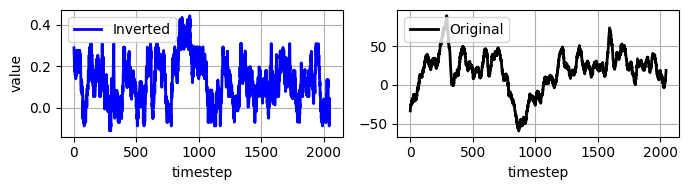

In [49]:
import matplotlib.pyplot as plt

# Get the data
example_idx = 1000
inverted_data = inverter(dataset[example_idx]['data'].unsqueeze(0).to(device, dtype=dtype)).detach().cpu().float().numpy().flatten()
inverted_data = embedder(inverter(dataset[example_idx]['data'].unsqueeze(0).to(device, dtype=dtype)).reshape(1, -1, 1, 1)).detach().cpu().float().numpy().flatten()
original_data = dataset[example_idx]['data'].unsqueeze(0).detach().cpu().float().numpy().flatten()

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2))

# Plot inverted data on first axis
ax1.plot(inverted_data, color='blue', linewidth=2, label='Inverted')
ax1.set_xlabel('timestep')
ax1.set_ylabel('value') 
ax1.grid(True)
ax1.legend(loc='upper left')

# Plot original data on second axis
ax2.plot(original_data, color='k', linewidth=2, label='Original')
ax2.set_xlabel('timestep')
ax2.grid(True)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

Processed btbank3_1_embed128_hilbert2_bits3.json
Processed btbank3_1_embed128_hilbert2_bits4.json
Processed btbank3_1_embed128_hilbert2_bits5.json
Processed btbank3_1_embed128_hilbert2_bits6.json
Processed btbank3_1_embed128_hilbert3_bits3.json
Processed btbank3_1_embed128_hilbert3_bits4.json
Processed btbank3_1_embed128_hilbert3_bits5.json
Processed btbank3_1_embed128_hilbert3_bits6.json
Processed btbank3_1_embed128_hilbert4_bits3.json
Processed btbank3_1_embed128_hilbert4_bits4.json
Processed btbank3_1_embed128_hilbert4_bits5.json
Processed btbank3_1_embed128_hilbert4_bits6.json
Processed btbank3_1_embed128_hilbert5_bits3.json
Processed btbank3_1_embed128_hilbert5_bits4.json
Processed btbank3_1_embed128_hilbert5_bits5.json
Processed btbank3_1_embed128_hilbert5_bits6.json
Processed btbank3_1_embed128_hilbert6_bits3.json
Processed btbank3_1_embed128_hilbert6_bits4.json
Processed btbank3_1_embed128_hilbert6_bits5.json
Processed btbank3_1_embed128_hilbert6_bits6.json


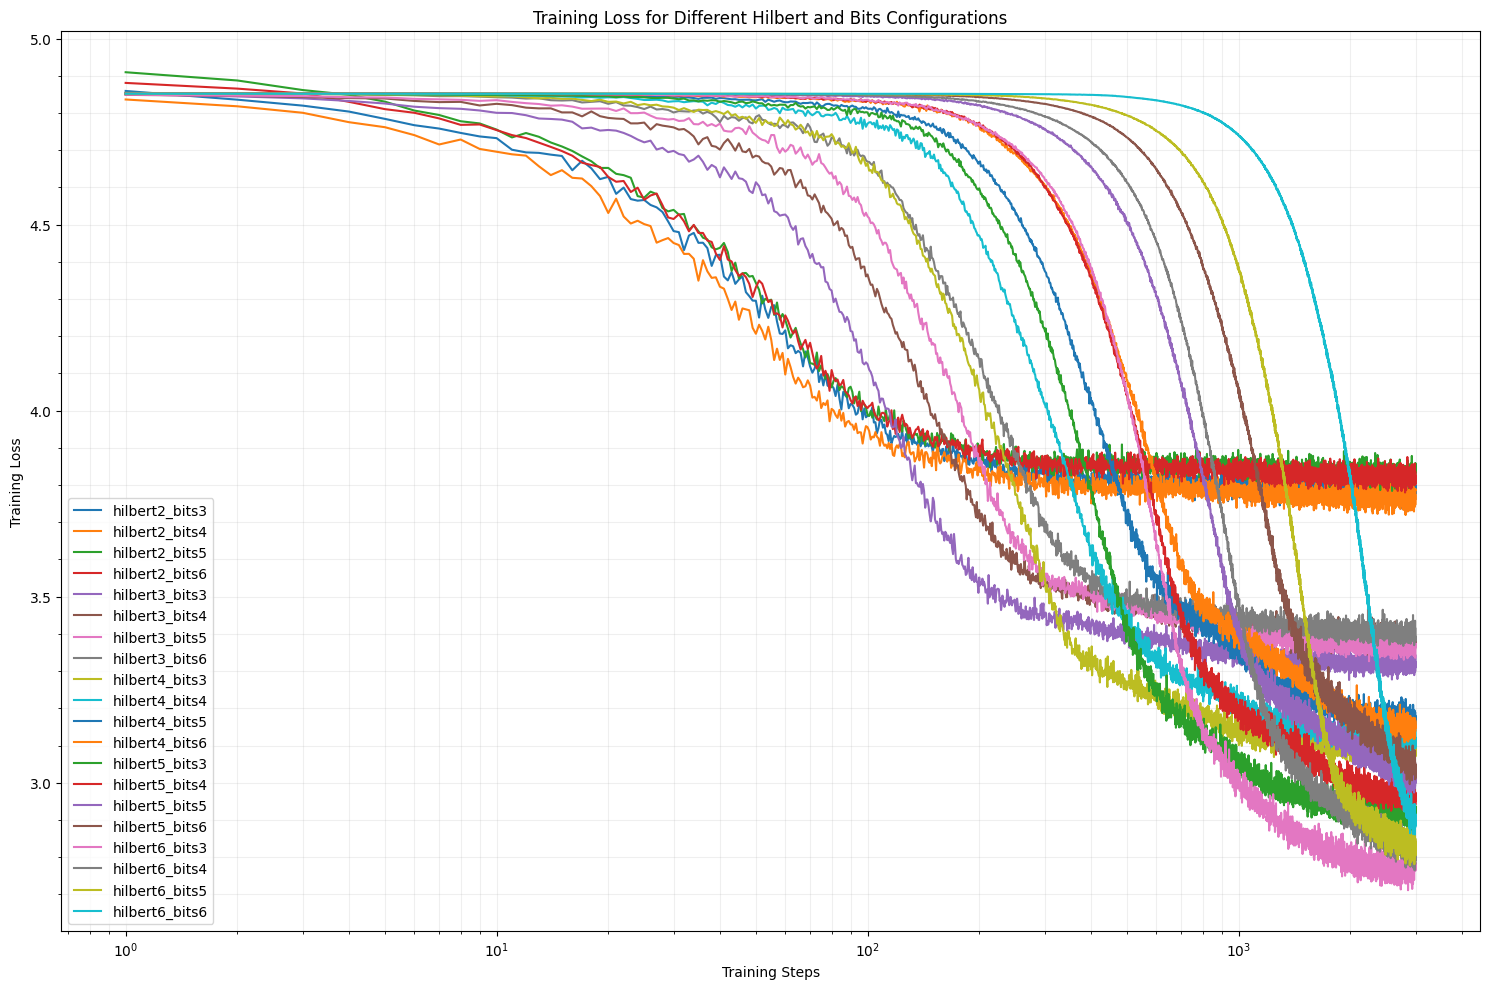

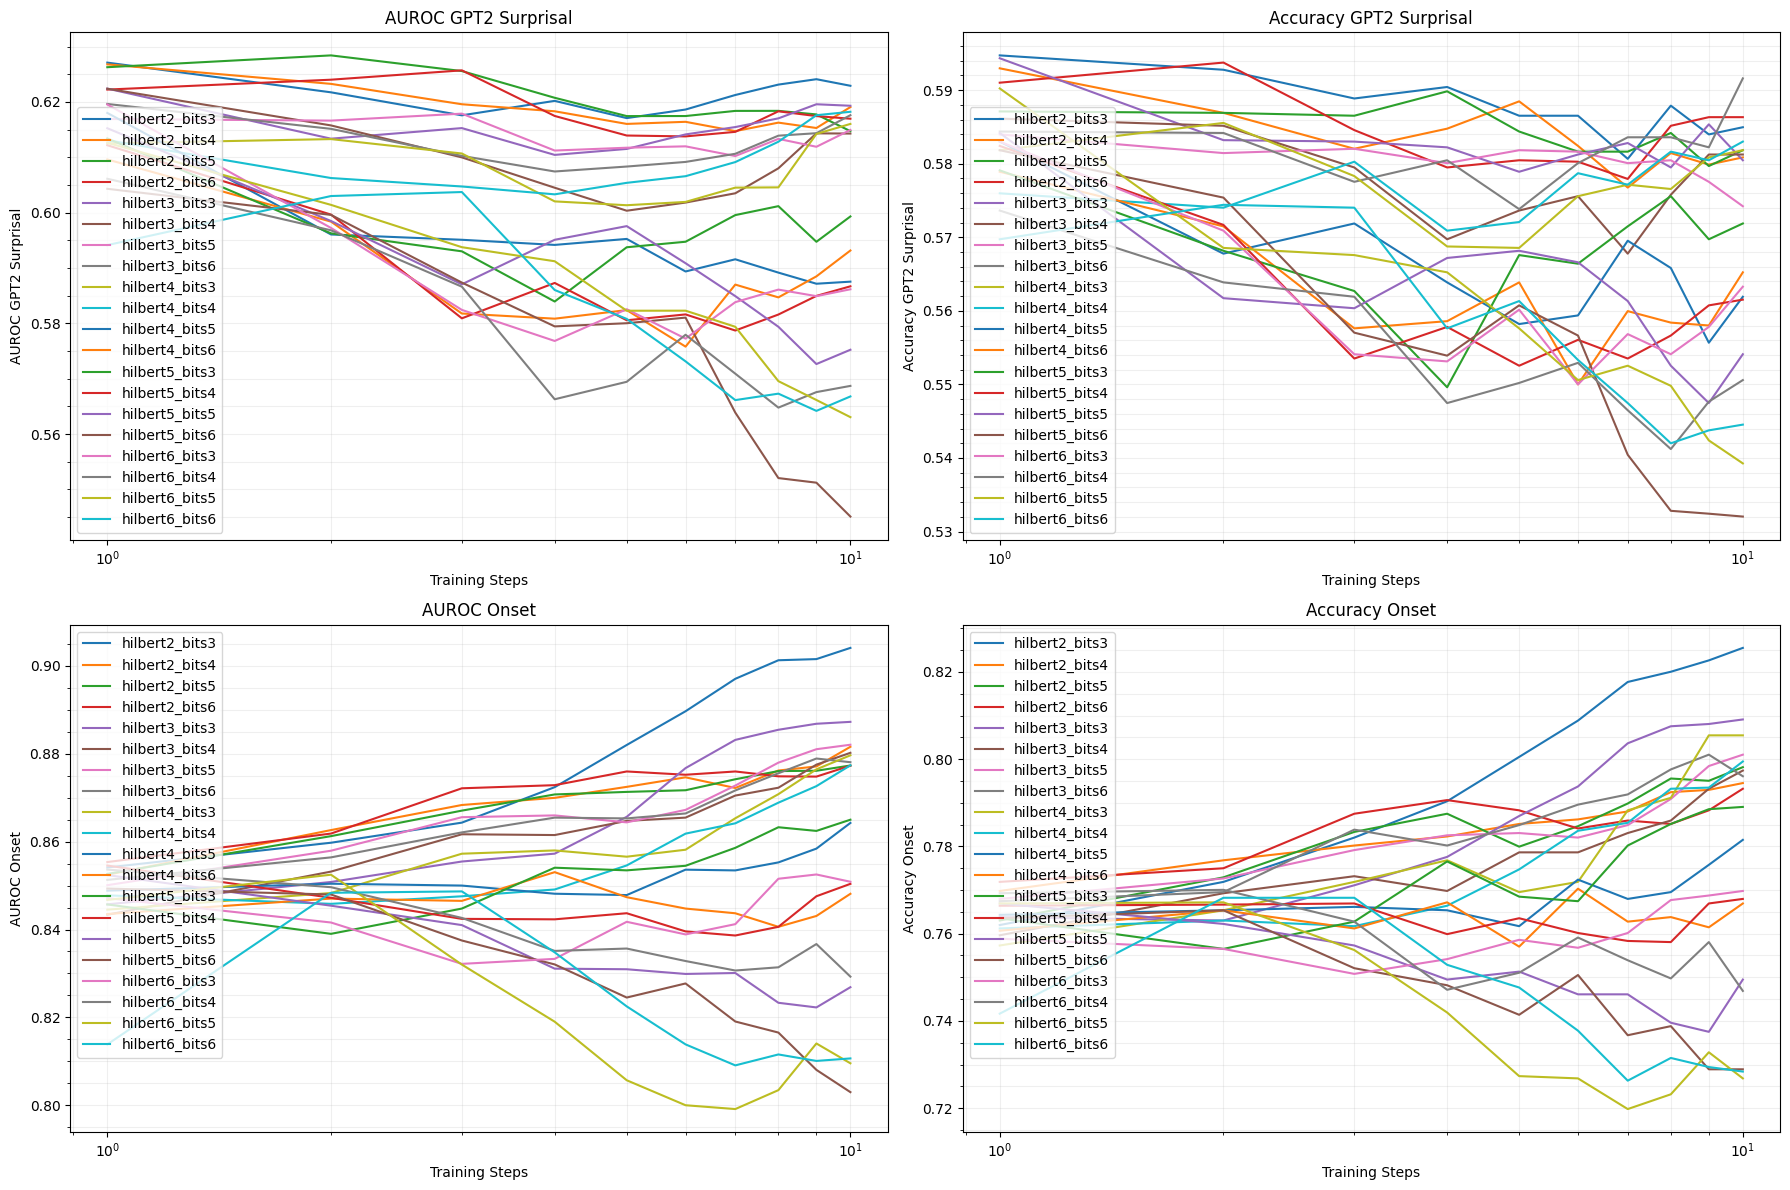

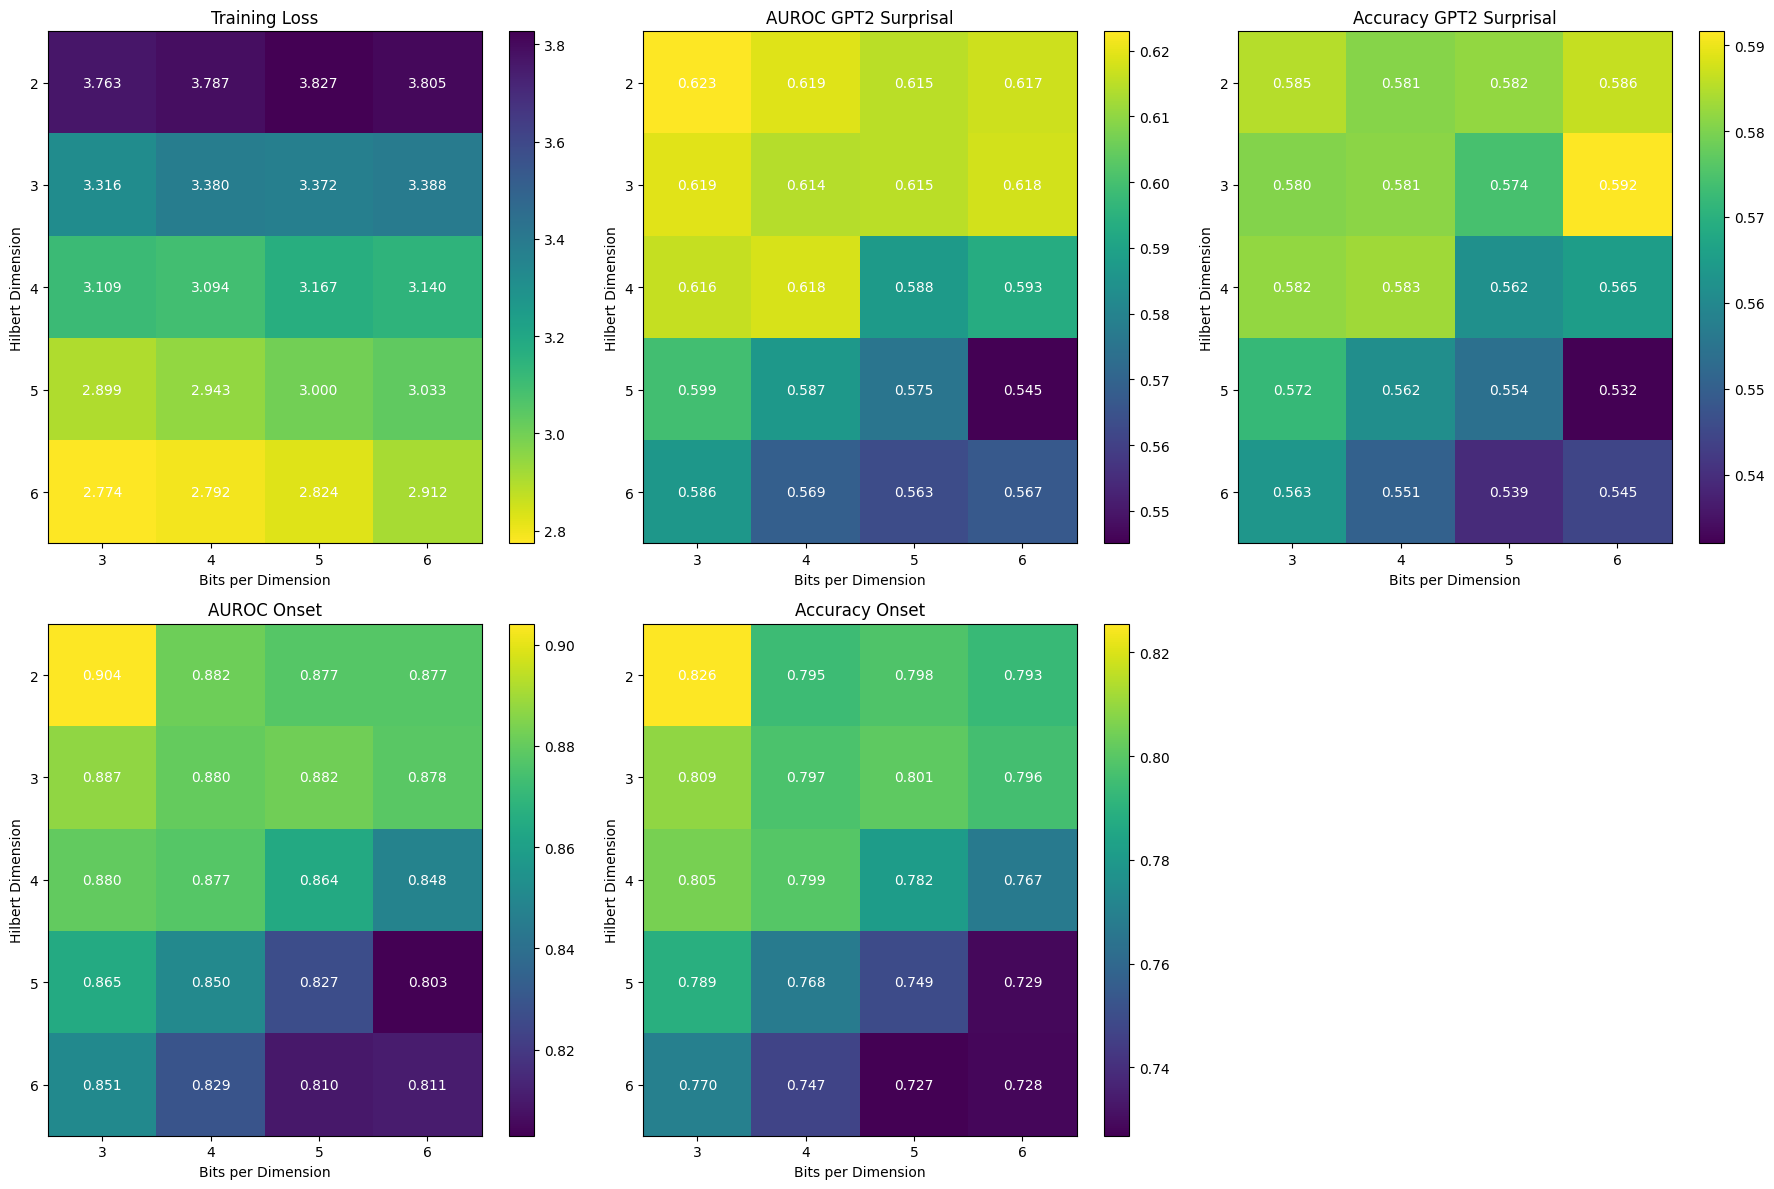


Best Configurations:
--------------------------------------------------------------------------------
Training Loss            : hilbert6_bits3 (value: 2.7744)
AUROC GPT2 Surprisal     : hilbert2_bits3 (value: 0.6229)
Accuracy GPT2 Surprisal  : hilbert3_bits6 (value: 0.5916)
AUROC Onset              : hilbert2_bits3 (value: 0.9041)
Accuracy Onset           : hilbert2_bits3 (value: 0.8255)


In [21]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# Define the combinations to loop through
d_hilbert_values = [2, 3, 4, 5, 6]
bits_per_dimension_values = [3, 4, 5, 6]

# Create figures to plot the training loss and metrics curves
plt.figure(figsize=(15, 10))

# Dictionary to store the metrics for heatmaps
metrics_grid = {
    'loss': np.zeros((len(d_hilbert_values), len(bits_per_dimension_values))),
    'auroc_gpt2': np.zeros((len(d_hilbert_values), len(bits_per_dimension_values))),
    'acc_gpt2': np.zeros((len(d_hilbert_values), len(bits_per_dimension_values))),
    'auroc_onset': np.zeros((len(d_hilbert_values), len(bits_per_dimension_values))),
    'acc_onset': np.zeros((len(d_hilbert_values), len(bits_per_dimension_values)))
}

# Dictionary to track if data exists for each grid position
data_exists = np.zeros((len(d_hilbert_values), len(bits_per_dimension_values)), dtype=bool)

# Dictionary to store metrics over time for each configuration
metrics_over_time = {
    'steps': [],
    'loss': {},
    'auroc_gpt2': {},
    'acc_gpt2': {},
    'auroc_onset': {},
    'acc_onset': {}
}

# Loop through all combinations
for i, d_hilbert in enumerate(d_hilbert_values):
    for j, bits in enumerate(bits_per_dimension_values):
        # Construct the filename based on the pattern in file_context_0
        filename = f'btbank3_1_embed128_hilbert{d_hilbert}_bits{bits}.json'
        filepath = os.path.join('eval_results/single_electrode_new/', filename)
        
        config_name = f'hilbert{d_hilbert}_bits{bits}'
        
        try:
            # Try to open and load the JSON file
            with open(filepath, 'r') as f:
                data = json.load(f)
            
            # Extract training loss and metrics over time
            steps = [entry['step'] for entry in data if 'step' in entry]
            losses = [entry['train_loss'] for entry in data if 'train_loss' in entry]
            
            # Initialize metric lists in the dictionary if this is the first valid data
            if len(metrics_over_time['steps']) == 0 and len(steps) > 0:
                metrics_over_time['steps'] = steps
            
            # Store metrics over time
            metrics_over_time['loss'][config_name] = losses
            
            # Extract other metrics over time
            auroc_gpt2_values = [entry.get('eval_auroc/average_gpt2_surprisal', np.nan) for entry in data if 'eval_auroc/average_gpt2_surprisal' in entry]
            acc_gpt2_values = [entry.get('eval_acc/average_gpt2_surprisal', np.nan) for entry in data if 'eval_acc/average_gpt2_surprisal' in entry]
            auroc_onset_values = [entry.get('eval_auroc/average_onset', np.nan) for entry in data if 'eval_auroc/average_onset' in entry]
            acc_onset_values = [entry.get('eval_acc/average_onset', np.nan) for entry in data if 'eval_acc/average_onset' in entry]
            
            # Store these metrics
            metrics_over_time['auroc_gpt2'][config_name] = auroc_gpt2_values
            metrics_over_time['acc_gpt2'][config_name] = acc_gpt2_values
            metrics_over_time['auroc_onset'][config_name] = auroc_onset_values
            metrics_over_time['acc_onset'][config_name] = acc_onset_values
            
            # Plot training loss
            plt.plot(steps, losses, label=config_name)
            
            # Extract final evaluation metrics (from the last entry)
            last_entry = data[-1]
            if 'eval_auroc/average_gpt2_surprisal' in last_entry and 'eval_acc/average_gpt2_surprisal' in last_entry:
                # Store metrics in the grid
                metrics_grid['loss'][i, j] = last_entry.get('train_loss', np.nan)
                metrics_grid['auroc_gpt2'][i, j] = last_entry.get('eval_auroc/average_gpt2_surprisal', np.nan)
                metrics_grid['acc_gpt2'][i, j] = last_entry.get('eval_acc/average_gpt2_surprisal', np.nan)
                metrics_grid['auroc_onset'][i, j] = last_entry.get('eval_auroc/average_onset', np.nan)
                metrics_grid['acc_onset'][i, j] = last_entry.get('eval_acc/average_onset', np.nan)
                data_exists[i, j] = True
            
            print(f"Processed {filename}")
        except FileNotFoundError:
            print(f"File not found: {filepath}")
        except json.JSONDecodeError:
            print(f"Error decoding JSON from {filepath}")
        except Exception as e:
            print(f"Error processing {filepath}: {str(e)}")

# Finalize and show the training loss plot
# Set x-axis to logarithmic scale
plt.xscale('log')

# Add grid lines that are visible with log scale
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.minorticks_on()

plt.xlabel('Training Steps')
plt.ylabel('Training Loss')
plt.title('Training Loss for Different Hilbert and Bits Configurations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create plots for each metric over time
metric_names = ['auroc_gpt2', 'acc_gpt2', 'auroc_onset', 'acc_onset']
titles = ['AUROC GPT2 Surprisal', 'Accuracy GPT2 Surprisal', 'AUROC Onset', 'Accuracy Onset']

fig, axs = plt.subplots(2, 2, figsize=(18, 12))
axs = axs.flatten()

for i, (metric, title) in enumerate(zip(metric_names, titles)):
    ax = axs[i]
    for config_name, values in metrics_over_time[metric].items():
        if len(values) > 0:  # Only plot if we have data
            ax.plot(metrics_over_time['steps'][:len(values)], values, label=config_name)
    
    ax.set_title(title)
    ax.set_xlabel('Training Steps')
    ax.set_ylabel(title)
    ax.set_xscale('log')
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.minorticks_on()
    ax.legend()

plt.tight_layout()
plt.show()

# Create heatmaps for each metric
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

# Define metric names and titles for heatmaps
metric_names = ['loss', 'auroc_gpt2', 'acc_gpt2', 'auroc_onset', 'acc_onset']
titles = ['Training Loss', 'AUROC GPT2 Surprisal', 'Accuracy GPT2 Surprisal', 'AUROC Onset', 'Accuracy Onset']

# Create a mask for positions where data doesn't exist
mask = ~data_exists

# Plot each metric as a heatmap
for i, (metric, title) in enumerate(zip(metric_names, titles)):
    if i < len(axs):
        # Create a masked array
        masked_data = np.ma.array(metrics_grid[metric], mask=mask)
        
        # For loss, lower is better, so use a reversed colormap
        cmap = 'viridis_r' if metric == 'loss' else 'viridis'
        
        im = axs[i].imshow(masked_data, cmap=cmap, aspect='auto')
        axs[i].set_title(title)
        axs[i].set_xlabel('Bits per Dimension')
        axs[i].set_ylabel('Hilbert Dimension')
        axs[i].set_xticks(np.arange(len(bits_per_dimension_values)))
        axs[i].set_yticks(np.arange(len(d_hilbert_values)))
        axs[i].set_xticklabels(bits_per_dimension_values)
        axs[i].set_yticklabels(d_hilbert_values)
        
        # Add colorbar
        plt.colorbar(im, ax=axs[i])
        
        # Add text annotations with values
        for ii in range(len(d_hilbert_values)):
            for jj in range(len(bits_per_dimension_values)):
                if not mask[ii, jj]:
                    text = axs[i].text(jj, ii, f"{metrics_grid[metric][ii, jj]:.3f}",
                                      ha="center", va="center", color="w" if metrics_grid[metric][ii, jj] > 0.5 else "k")

# Remove the unused subplot if any
if len(metric_names) < len(axs):
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()

# Print a summary of the best configurations for each metric
print("\nBest Configurations:")
print("-" * 80)
for metric, title in zip(metric_names, titles):
    if metric == 'loss':
        # For loss, lower is better
        best_idx = np.ma.argmin(np.ma.array(metrics_grid[metric], mask=mask))
    else:
        # For other metrics, higher is better
        best_idx = np.ma.argmax(np.ma.array(metrics_grid[metric], mask=mask))
    
    # Convert flat index to 2D coordinates
    best_i, best_j = np.unravel_index(best_idx, (len(d_hilbert_values), len(bits_per_dimension_values)))
    
    best_value = metrics_grid[metric][best_i, best_j]
    best_config = f"hilbert{d_hilbert_values[best_i]}_bits{bits_per_dimension_values[best_j]}"
    
    print(f"{title:<25}: {best_config} (value: {best_value:.4f})")



Initial Values (First Evaluation):
--------------------------------------------------------------------------------
eval_auroc/average_frame_brightness               : 0.487586
eval_auroc/average_global_flow                    : 0.521851
eval_auroc/average_local_flow                     : 0.533750
eval_auroc/average_global_flow_angle              : 0.486963
eval_auroc/average_local_flow_angle               : 0.434835
eval_auroc/average_face_num                       : 0.510018
eval_auroc/average_volume                         : 0.596031
eval_auroc/average_pitch                          : 0.541229
eval_auroc/average_delta_volume                   : 0.728495
eval_auroc/average_delta_pitch                    : 0.523402
eval_auroc/average_speech                         : 0.739552
eval_auroc/average_onset                          : 0.830277
eval_auroc/average_gpt2_surprisal                 : 0.628871
eval_auroc/average_word_length                    : 0.597163
eval_auroc/average_word_gap  

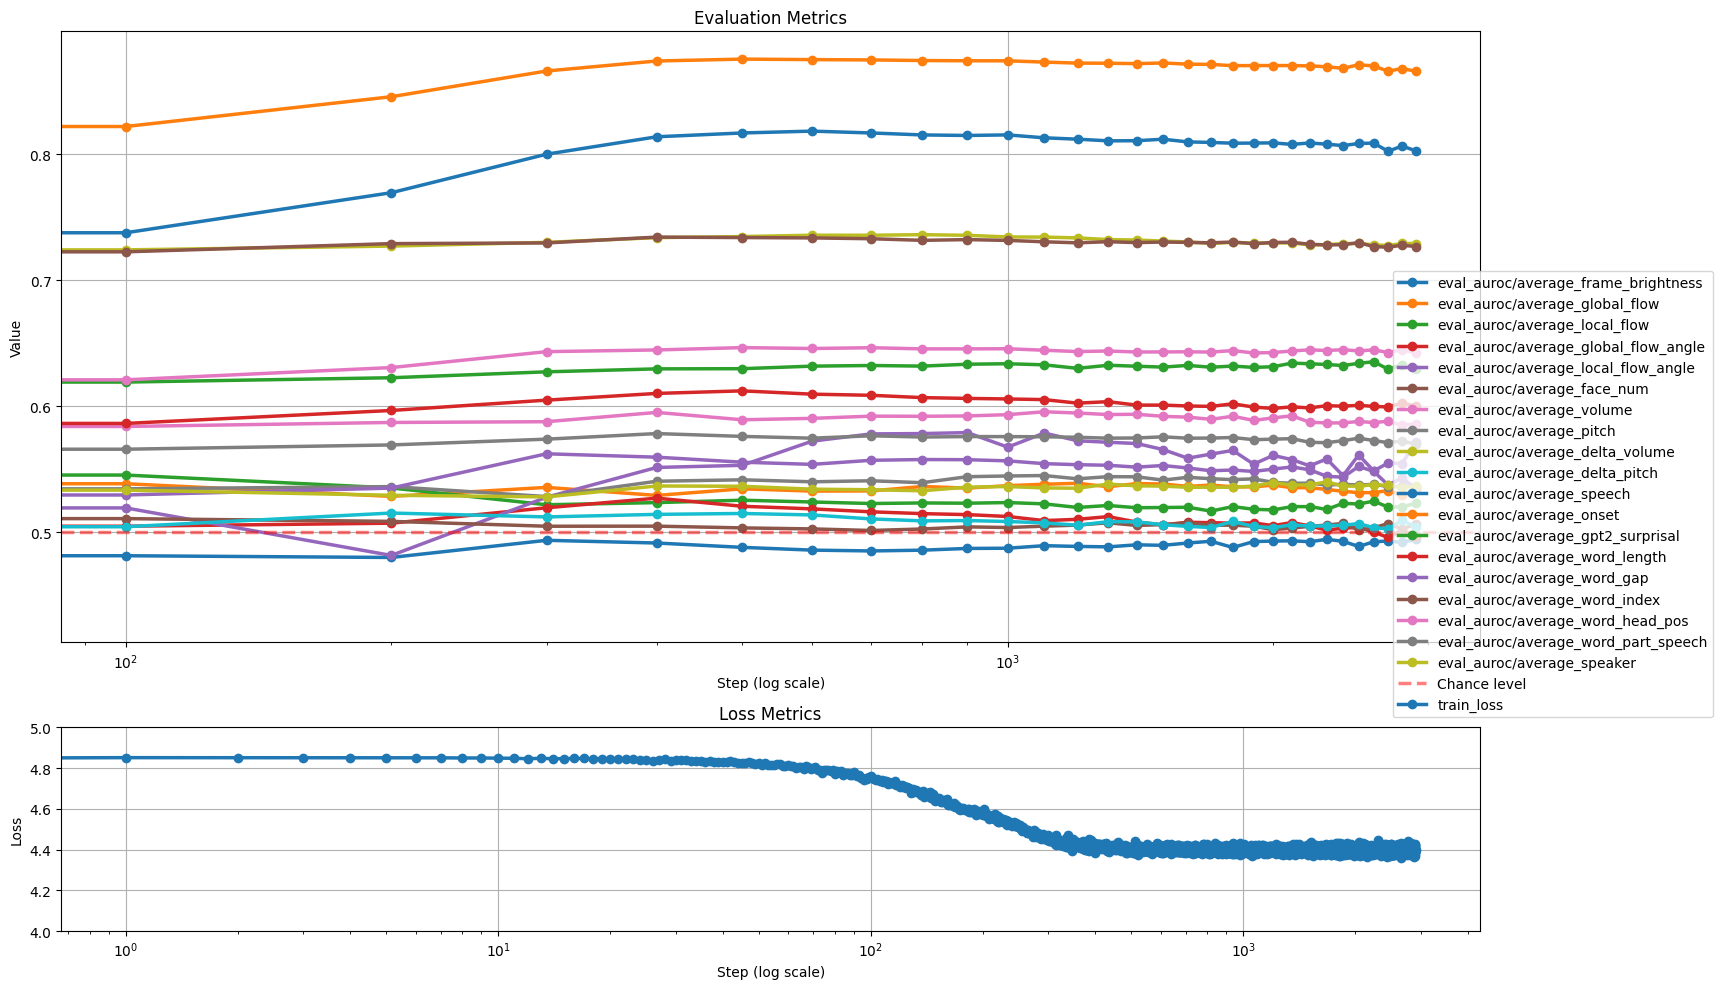

In [9]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON file
json_file_path = "eval_results/single_electrode_new_lin/btbank3_1_embed128_resolution2.json"
try:
    with open(json_file_path, 'r') as f:
        results = json.load(f)
except FileNotFoundError:
    print(f"File not found: {json_file_path}")
    results = {}

if results:
    # Organize metrics and their corresponding steps
    eval_metrics = {}
    loss_metrics = {}
    steps = {}
    
    for entry in results:
        if 'step' in entry:
            step = entry['step']
            
            # Add all metrics to the appropriate dictionary
            for key, value in entry.items():
                if key != 'step':
                    if 'loss' in key:
                        if key not in loss_metrics:
                            loss_metrics[key] = []
                            steps[key] = []
                        loss_metrics[key].append(value)
                        steps[key].append(step)
                    elif 'auroc' in key and 'average' in key:
                        if key not in eval_metrics:
                            eval_metrics[key] = []
                            steps[key] = []
                        eval_metrics[key].append(value)
                        steps[key].append(step)
    
    # Print initial values (step -1 or the first evaluation)
    print("\nInitial Values (First Evaluation):")
    print("-" * 80)
    first_entry = results[0] if results else {}
    for key, value in first_entry.items():
        if key != 'step' and 'auroc' in key and 'average' in key:
            print(f"{key:<50}: {value:.6f}")
    
    # Create a figure with two subplots with different heights (first one taller)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})
    
    # Plot all evaluation metrics on the first subplot with thicker lines
    for metric_name, metric_values in eval_metrics.items():
        ax1.semilogx(steps[metric_name], metric_values, 'o-', label=metric_name, linewidth=2.5)
    
    ax1.set_title('Evaluation Metrics')
    ax1.set_xlabel('Step (log scale)')
    ax1.set_ylabel('Value')
    ax1.grid(True)
    ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Chance level', linewidth=2.5)
    
    # Plot loss metrics on the second subplot with thicker lines
    for metric_name, metric_values in loss_metrics.items():
        ax2.semilogx(steps[metric_name], metric_values, 'o-', label=metric_name, linewidth=2.5)
    
    ax2.set_title('Loss Metrics')
    ax2.set_xlabel('Step (log scale)')
    ax2.set_ylabel('Loss')
    ax2.grid(True)
    ax2.set_ylim(4, 5)
    
    # Place legend to the right of the whole figure
    fig.tight_layout()
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(handles1 + handles2, labels1 + labels2, loc='center right', bbox_to_anchor=(1.15, 0.5))
    
    plt.tight_layout()
    plt.show()
else:
    print("No data loaded from the JSON file.")


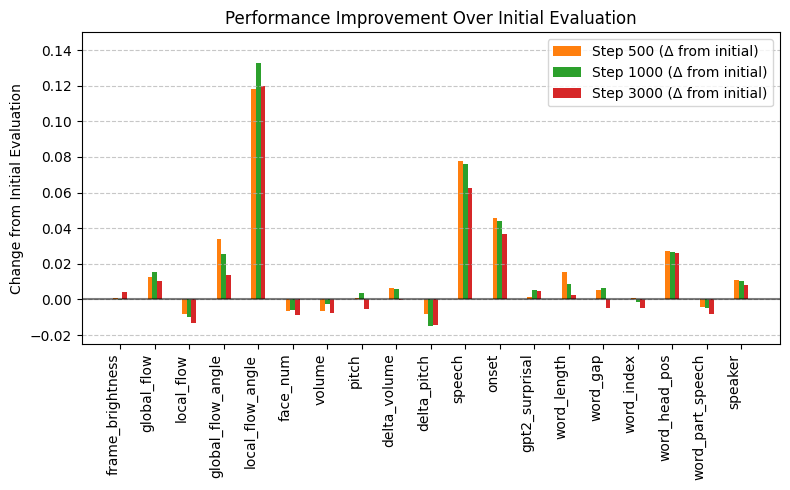


Metrics at Selected Training Steps (Δ from initial):
--------------------------------------------------------------------------------
Baseline (Step 0):
  eval_auroc/average_frame_brightness: 0.487586
  eval_auroc/average_global_flow: 0.521851
  eval_auroc/average_local_flow: 0.533750
  eval_auroc/average_global_flow_angle: 0.486963
  eval_auroc/average_local_flow_angle: 0.434835
  eval_auroc/average_face_num: 0.510018
  eval_auroc/average_volume: 0.596031
  eval_auroc/average_pitch: 0.541229
  eval_auroc/average_delta_volume: 0.728495
  eval_auroc/average_delta_pitch: 0.523402
  eval_auroc/average_speech: 0.739552
  eval_auroc/average_onset: 0.830277
  eval_auroc/average_gpt2_surprisal: 0.628871
  eval_auroc/average_word_length: 0.597163
  eval_auroc/average_word_gap: 0.550216
  eval_auroc/average_word_index: 0.733219
  eval_auroc/average_word_head_pos: 0.619318
  eval_auroc/average_word_part_speech: 0.580667
  eval_auroc/average_speaker: 0.525961
------------------------------------

In [20]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON file
json_file_path = "eval_results/single_electrode_new_lin/btbank3_1_embed128_resolution2.json"
try:
    with open(json_file_path, 'r') as f:
        results = json.load(f)
except FileNotFoundError:
    print(f"File not found: {json_file_path}")
    results = {}

if results:
    # Define the steps we want to compare
    target_steps = [0, 500, 1000, 3000]  # 0 represents the initial evaluation
    
    # Organize metrics by step
    metrics_by_step = {}
    for step in target_steps:
        metrics_by_step[step] = {}
    
    # Extract metrics at or closest to the target steps
    for entry in results:
        if 'step' in entry:
            current_step = entry['step']
            
            # Find the closest target step
            closest_step = min(target_steps, key=lambda x: abs(x - current_step))
            
            # Only update if this is closer than any previously found entry for this target step
            if closest_step not in metrics_by_step or 'closest_actual' not in metrics_by_step[closest_step] or \
               abs(current_step - closest_step) < abs(metrics_by_step[closest_step]['closest_actual'] - closest_step):
                
                # Store all metrics for this step
                metrics_by_step[closest_step] = {k: v for k, v in entry.items() if k != 'step'}
                metrics_by_step[closest_step]['closest_actual'] = current_step
    
    # Get the metrics we want to plot (AUROC metrics with 'average' in the name)
    metrics_to_plot = [k for k in metrics_by_step[target_steps[0]] if 'auroc' in k.lower() and 'average' in k.lower()]
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Number of metrics and steps (excluding the initial step which will be the baseline)
    n_metrics = len(metrics_to_plot)
    n_steps = len(target_steps) - 1  # Exclude the initial step (0)
    
    # Set width of bars and spacing between groups
    bar_width = 0.6 / n_steps  # Reduced width to create more space
    group_spacing = 1.5  # Increased spacing between groups
    
    # Set positions for bars
    indices = np.arange(n_metrics) * group_spacing  # Multiply by group_spacing to create more space
    
    # Colors for different steps
    colors = ['#ff7f0e', '#2ca02c', '#d62728']  # Excluding the first color for initial step
    
    # Get baseline values from the initial step
    baseline_values = {}
    for metric in metrics_to_plot:
        if metric in metrics_by_step[target_steps[0]]:
            baseline_values[metric] = metrics_by_step[target_steps[0]][metric]
        else:
            baseline_values[metric] = 0
    
    # Plot bars for each step (excluding the initial step)
    for i, step in enumerate(target_steps[1:]):  # Skip the first step (0)
        values = []
        for metric in metrics_to_plot:
            if metric in metrics_by_step[step]:
                # Calculate the difference from the baseline
                diff = metrics_by_step[step][metric] - baseline_values[metric]
                values.append(diff)
            else:
                values.append(0)  # Default if metric not found
        
        bars = ax.bar(indices + i * bar_width, values, bar_width, 
                      label=f'Step {metrics_by_step[step]["closest_actual"]} (Δ from initial)', 
                      color=colors[i % len(colors)])
        
        # Add metric names on top of bars instead of values
        for bar_idx, bar in enumerate(bars):
            height = bar.get_height()
            metric = metrics_to_plot[bar_idx]
            # Extract the metric name after 'auroc/average_'
            if 'auroc/average_' in metric:
                metric_name = metric.split('auroc/average_')[1]
            else:
                metric_name = metric.replace('eval_auroc/', '')
            
            # va = 'bottom' if height >= 0 else 'top'
            # if i == 1:
            #     ax.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.01),
            #             metric_name, ha='center', va=va, rotation=0, fontsize=9)
            
            # Original value labels (commented out)
            # label = f'+{height:.3f}' if height > 0 else f'{height:.3f}'
            # ax.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.01),
            #         label, ha='center', va=va, rotation=0, fontsize=9)
    
    # Add a horizontal line at 0 (no change from baseline)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.5)
    
    # Customize the plot
    ax.set_ylabel('Change from Initial Evaluation')
    ax.set_title('Performance Improvement Over Initial Evaluation')
    ax.set_xticks(indices + bar_width * (n_steps-1) / 2)
    ax.set_xticklabels([metric.replace('eval_auroc/average_', '\n') for metric in metrics_to_plot], rotation=90, ha='right')
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Set y-axis limits to show the differences clearly
    max_abs_diff = max([abs(metrics_by_step[step].get(metric, 0) - baseline_values.get(metric, 0)) 
                        for step in target_steps[1:] for metric in metrics_to_plot])
    y_limit = max(0.1, max_abs_diff * 1.2)  # At least 0.1, or 20% more than the max difference
    ax.set_ylim(-0.025, 0.15)
    
    plt.tight_layout()
    plt.show()
    
    # Print the actual steps used and their values
    print("\nMetrics at Selected Training Steps (Δ from initial):")
    print("-" * 80)
    print(f"Baseline (Step {metrics_by_step[target_steps[0]]['closest_actual']}):")
    for metric in metrics_to_plot:
        if metric in metrics_by_step[target_steps[0]]:
            print(f"  {metric}: {metrics_by_step[target_steps[0]][metric]:.6f}")
    print("-" * 40)
    
    for step in target_steps[1:]:
        actual_step = metrics_by_step[step]['closest_actual']
        print(f"Step {actual_step} (Δ from initial):")
        for metric in metrics_to_plot:
            if metric in metrics_by_step[step]:
                diff = metrics_by_step[step][metric] - baseline_values[metric]
                sign = '+' if diff > 0 else ''
                print(f"  {metric}: {sign}{diff:.6f}")
        print("-" * 40)
else:
    print("No data loaded from the JSON file.")


## Discretization

Processed btbank3_1_embed128_resolution2.json
Processed btbank3_1_embed128_resolution4.json
Processed btbank3_1_embed128_resolution8.json
Processed btbank3_1_embed128_resolution16.json
Processed btbank3_1_embed128_resolution32.json
Processed btbank3_1_embed128_resolution64.json
Processed btbank3_1_embed128_resolution128.json
Processed btbank3_1_embed128_resolution256.json


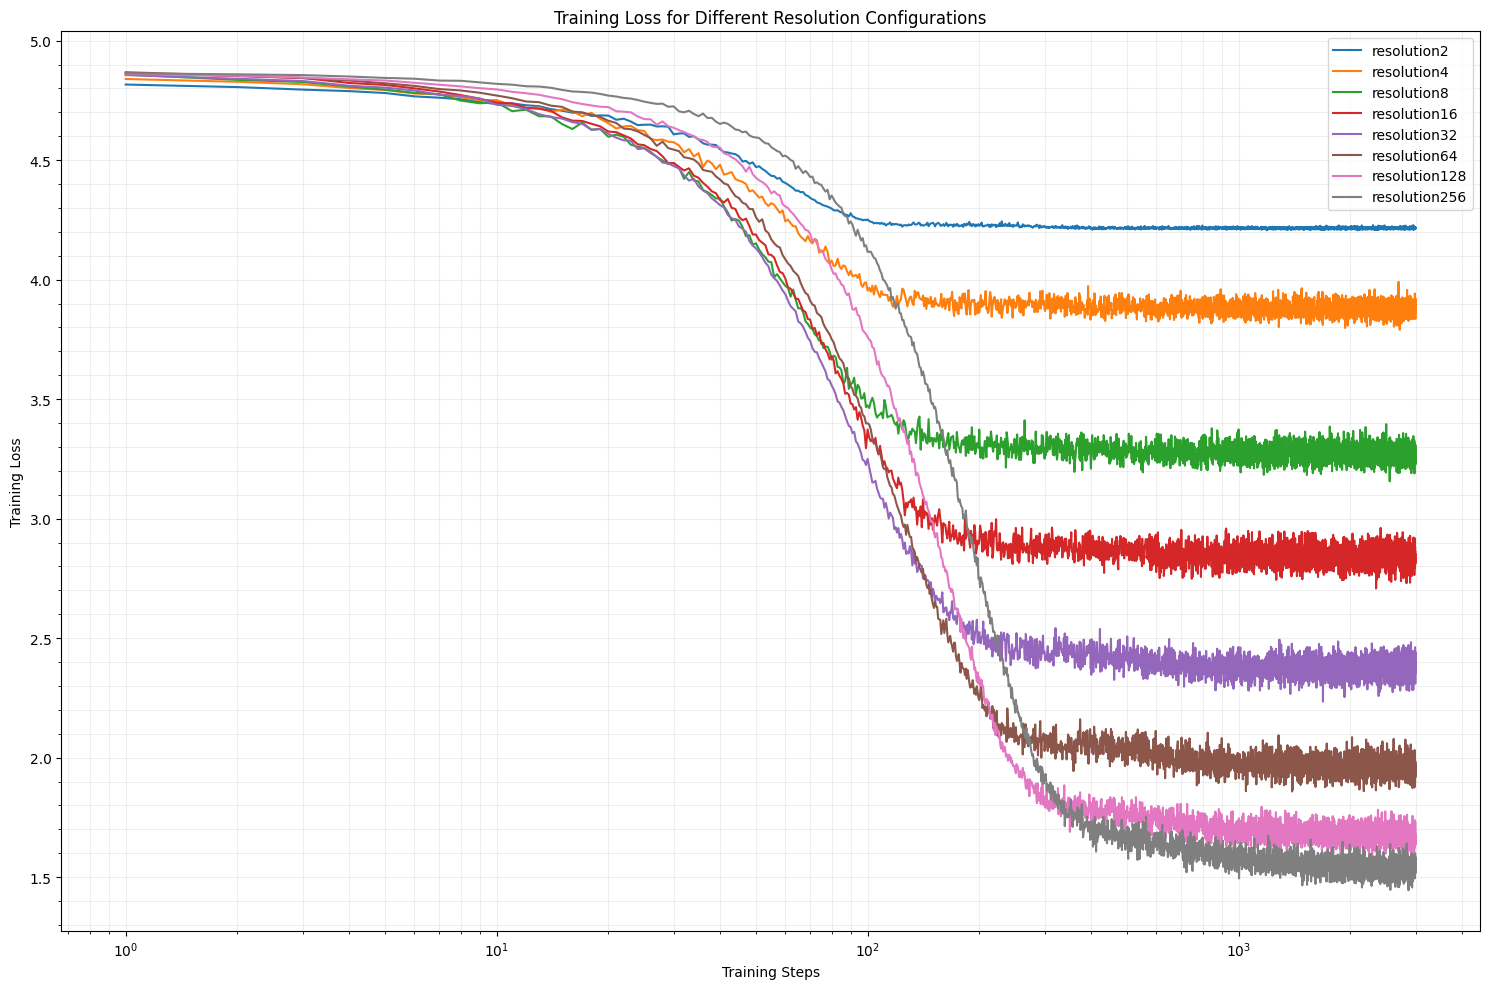

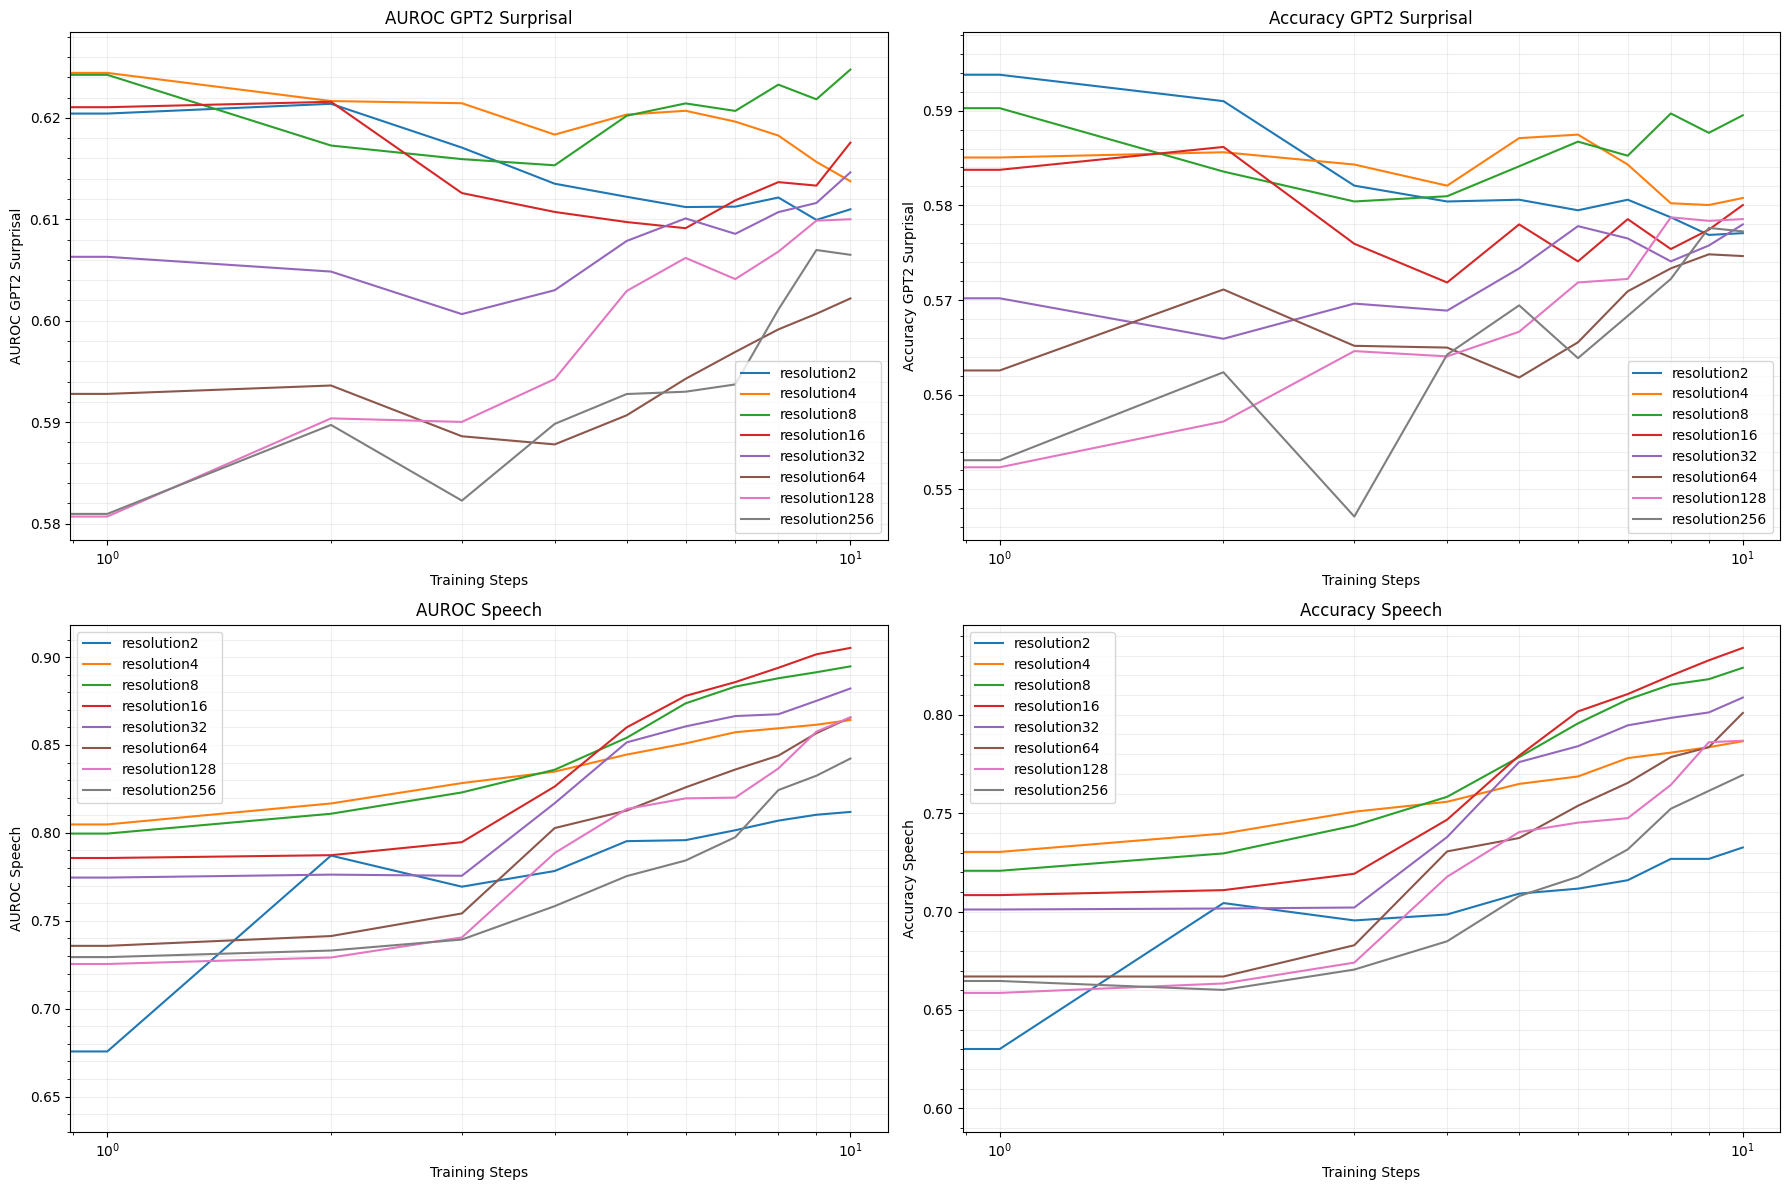

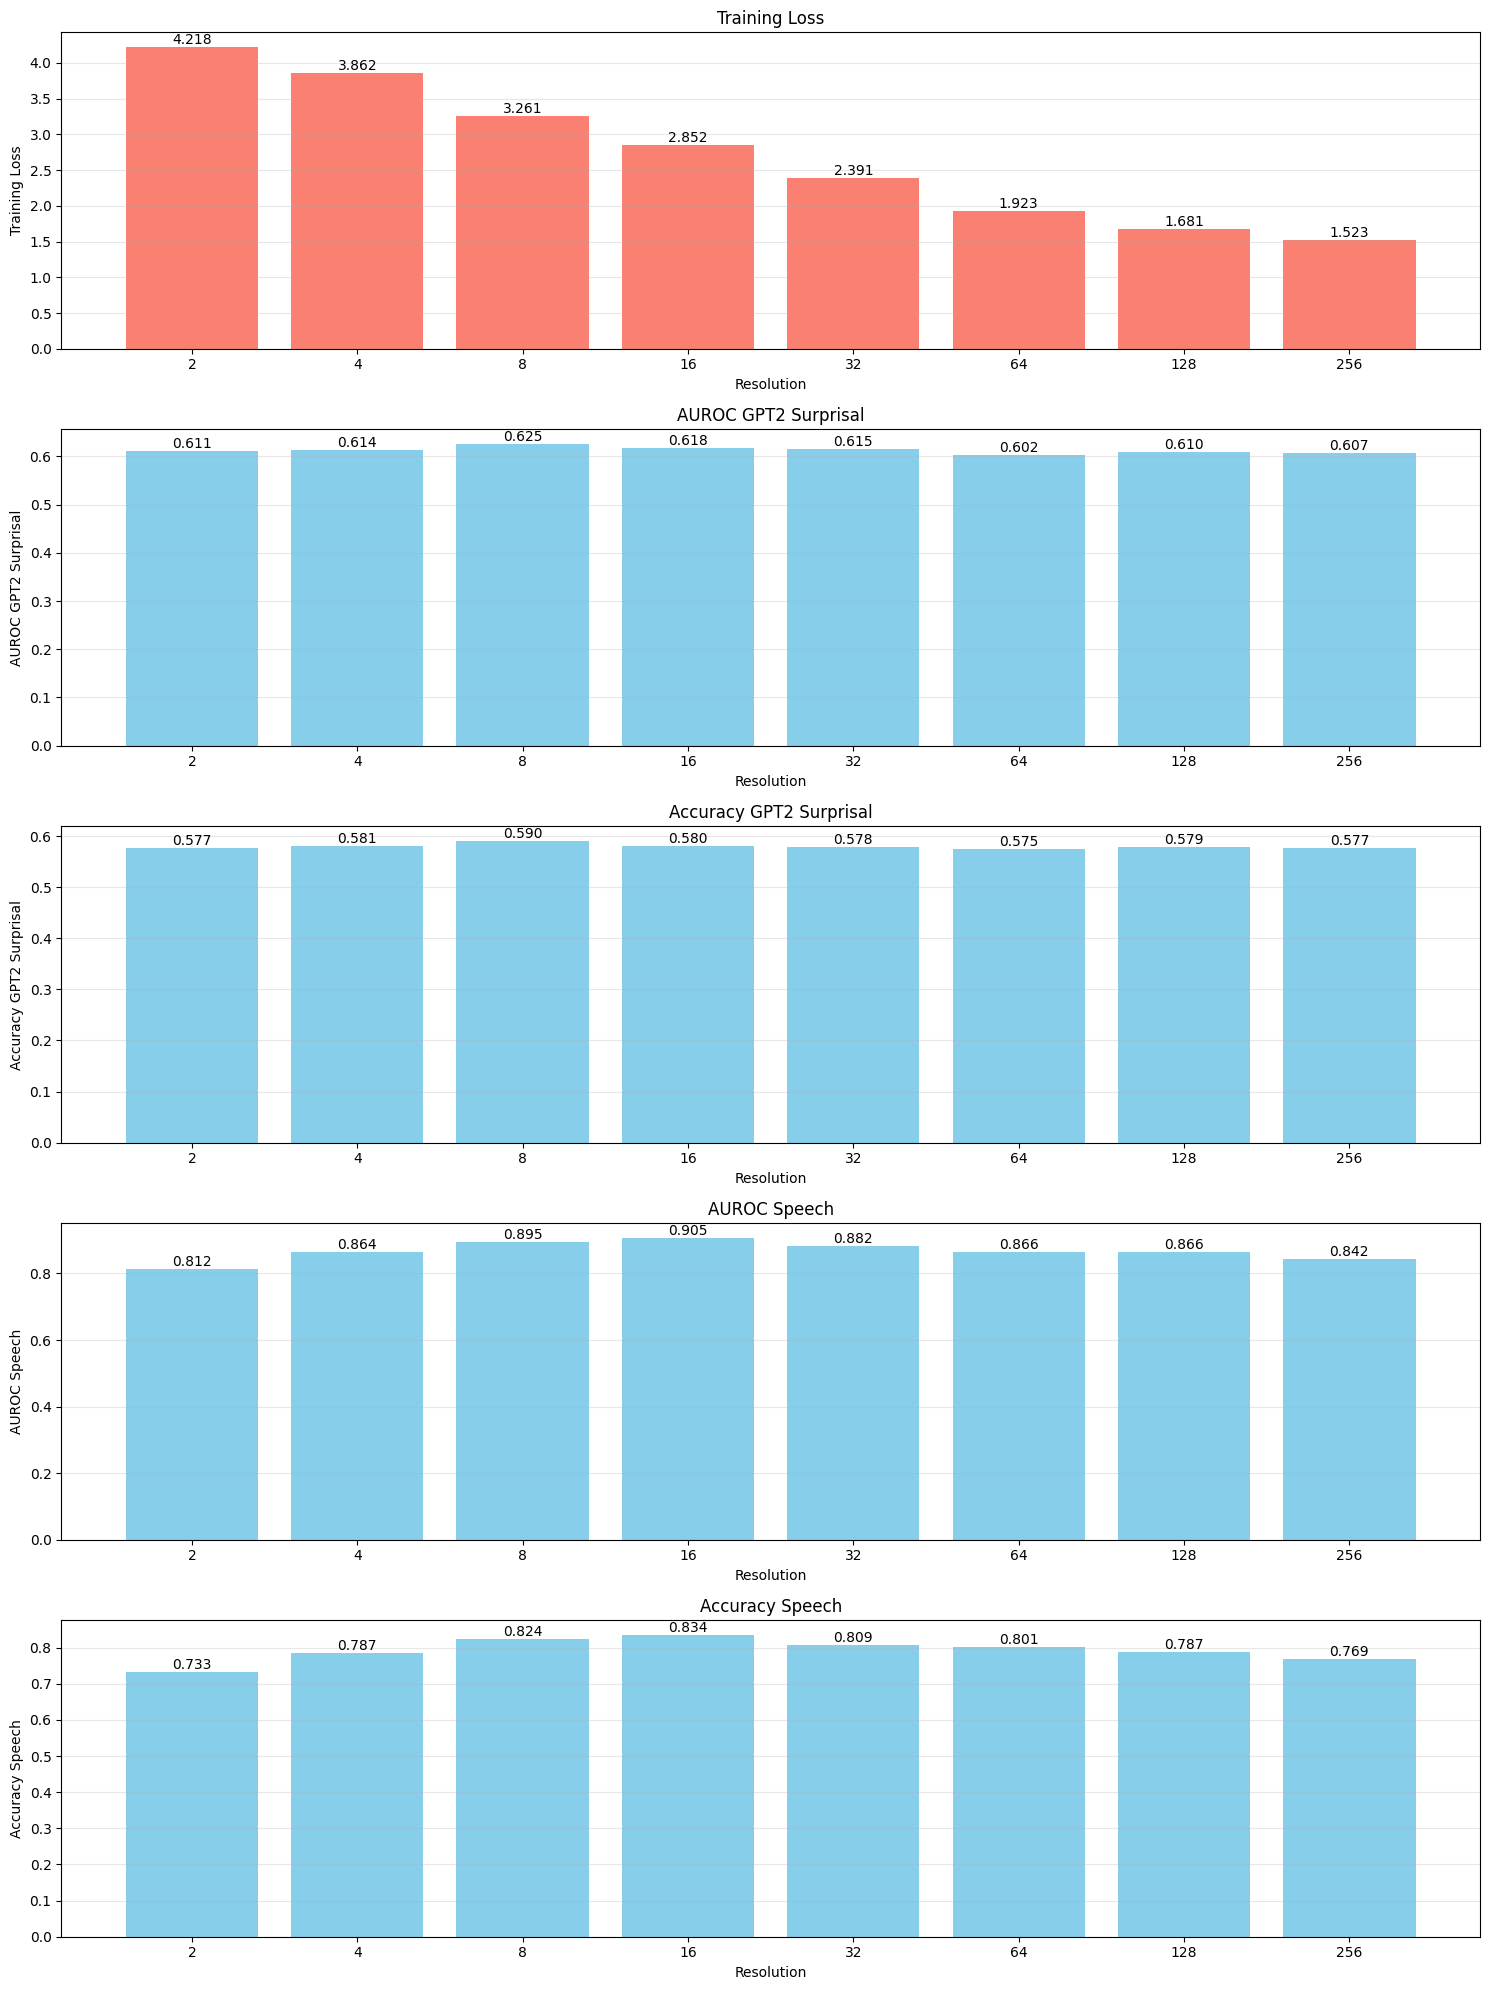


Best Configurations:
--------------------------------------------------------------------------------
Training Loss            : resolution256 (value: 1.5229)
AUROC GPT2 Surprisal     : resolution8 (value: 0.6248)
Accuracy GPT2 Surprisal  : resolution8 (value: 0.5895)
AUROC Speech             : resolution16 (value: 0.9052)
Accuracy Speech          : resolution16 (value: 0.8340)


In [3]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# Define the resolutions to loop through
resolutions = [2, 4, 8, 16, 32, 64, 128, 256]

# Create figures to plot the training loss and metrics curves
plt.figure(figsize=(15, 10))

# Dictionary to store the metrics for heatmaps
metrics_grid = {
    'loss': np.zeros(len(resolutions)),
    'auroc_gpt2': np.zeros(len(resolutions)),
    'acc_gpt2': np.zeros(len(resolutions)),
    'auroc_speech': np.zeros(len(resolutions)),
    'acc_speech': np.zeros(len(resolutions))
}

# Dictionary to track if data exists for each resolution
data_exists = np.zeros(len(resolutions), dtype=bool)

# Dictionary to store metrics over time for each configuration
metrics_over_time = {
    'steps': [],
    'loss': {},
    'auroc_gpt2': {},
    'acc_gpt2': {},
    'auroc_speech': {},
    'acc_speech': {}
}

# Loop through all resolutions
for i, resolution in enumerate(resolutions):
    # Construct the filename based on the pattern in file_context_0
    filename = f'btbank3_1_embed128_resolution{resolution}.json'
    filepath = os.path.join('eval_results/juno/', filename)
    
    config_name = f'resolution{resolution}'
    
    try:
        # Try to open and load the JSON file
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        # Extract training loss and metrics over time
        steps = [entry['step'] for entry in data if 'step' in entry]
        losses = [entry['train_loss'] for entry in data if 'train_loss' in entry and entry['train_loss'] != -1]
        
        # Initialize metric lists in the dictionary if this is the first valid data
        if len(metrics_over_time['steps']) == 0 and len(steps) > 0:
            metrics_over_time['steps'] = steps
        
        # Store metrics over time
        metrics_over_time['loss'][config_name] = losses
        
        # Extract other metrics over time
        auroc_gpt2_values = [entry.get('eval_auroc/average_gpt2_surprisal', np.nan) for entry in data if 'eval_auroc/average_gpt2_surprisal' in entry]
        acc_gpt2_values = [entry.get('eval_acc/average_gpt2_surprisal', np.nan) for entry in data if 'eval_acc/average_gpt2_surprisal' in entry]
        auroc_speech_values = [entry.get('eval_auroc/average_speech', np.nan) for entry in data if 'eval_auroc/average_speech' in entry]
        acc_speech_values = [entry.get('eval_acc/average_speech', np.nan) for entry in data if 'eval_acc/average_speech' in entry]
        
        # Store these metrics
        metrics_over_time['auroc_gpt2'][config_name] = auroc_gpt2_values
        metrics_over_time['acc_gpt2'][config_name] = acc_gpt2_values
        metrics_over_time['auroc_speech'][config_name] = auroc_speech_values
        metrics_over_time['acc_speech'][config_name] = acc_speech_values
        
        # Plot training loss
        plt.plot(steps[1:len(losses)+1], losses, label=config_name)
        
        # Extract final evaluation metrics (from the last entry)
        last_entry = data[-1]
        if 'eval_auroc/average_gpt2_surprisal' in last_entry and 'eval_acc/average_gpt2_surprisal' in last_entry:
            # Store metrics in the grid
            metrics_grid['loss'][i] = last_entry.get('train_loss', np.nan)
            metrics_grid['auroc_gpt2'][i] = last_entry.get('eval_auroc/average_gpt2_surprisal', np.nan)
            metrics_grid['acc_gpt2'][i] = last_entry.get('eval_acc/average_gpt2_surprisal', np.nan)
            metrics_grid['auroc_speech'][i] = last_entry.get('eval_auroc/average_speech', np.nan)
            metrics_grid['acc_speech'][i] = last_entry.get('eval_acc/average_speech', np.nan)
            data_exists[i] = True
        
        print(f"Processed {filename}")
    except FileNotFoundError:
        print(f"File not found: {filepath}")
    except json.JSONDecodeError:
        print(f"Error decoding JSON from {filepath}")
    except Exception as e:
        print(f"Error processing {filepath}: {str(e)}")

# Finalize and show the training loss plot
# Set x-axis to logarithmic scale
plt.xscale('log')

# Add grid lines that are visible with log scale
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.minorticks_on()

plt.xlabel('Training Steps')
plt.ylabel('Training Loss')
plt.title('Training Loss for Different Resolution Configurations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create plots for each metric over time
metric_names = ['auroc_gpt2', 'acc_gpt2', 'auroc_speech', 'acc_speech']
titles = ['AUROC GPT2 Surprisal', 'Accuracy GPT2 Surprisal', 'AUROC Speech', 'Accuracy Speech']

fig, axs = plt.subplots(2, 2, figsize=(18, 12))
axs = axs.flatten()

for i, (metric, title) in enumerate(zip(metric_names, titles)):
    ax = axs[i]
    for config_name, values in metrics_over_time[metric].items():
        if len(values) > 0:  # Only plot if we have data
            ax.plot(metrics_over_time['steps'][:len(values)], values, label=config_name)
    
    ax.set_title(title)
    ax.set_xlabel('Training Steps')
    ax.set_ylabel(title)
    ax.set_xscale('log')
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.minorticks_on()
    ax.legend()

plt.tight_layout()
plt.show()

# Define metric names and titles for bar plots
metric_names = ['loss', 'auroc_gpt2', 'acc_gpt2', 'auroc_speech', 'acc_speech']
titles = ['Training Loss', 'AUROC GPT2 Surprisal', 'Accuracy GPT2 Surprisal', 'AUROC Speech', 'Accuracy Speech']

# Create bar plots for each metric
fig, axs = plt.subplots(len(metric_names), 1, figsize=(15, 4*len(metric_names)))
if len(metric_names) == 1:
    axs = [axs]

# Create a mask for positions where data doesn't exist
mask = ~data_exists

# Plot each metric as a bar chart
for i, (metric, title) in enumerate(zip(metric_names, titles)):
    # Create a masked array
    masked_data = np.ma.array(metrics_grid[metric], mask=mask)
    
    # For loss, lower is better, so use a different color
    color = 'salmon' if metric == 'loss' else 'skyblue'
    
    # Plot bars for resolutions where data exists
    x_pos = np.arange(len(resolutions))
    axs[i].bar(x_pos[~mask], masked_data[~mask], color=color)
    
    # Add value labels on top of bars
    for j, value in enumerate(masked_data):
        if not np.ma.is_masked(value):
            axs[i].text(j, value, f"{value:.3f}", ha='center', va='bottom')
    
    axs[i].set_title(title)
    axs[i].set_xlabel('Resolution')
    axs[i].set_ylabel(title)
    axs[i].set_xticks(x_pos)
    axs[i].set_xticklabels(resolutions)
    axs[i].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print a summary of the best configurations for each metric
print("\nBest Configurations:")
print("-" * 80)
for metric, title in zip(metric_names, titles):
    # Create a masked array
    masked_data = np.ma.array(metrics_grid[metric], mask=mask)
    
    if metric == 'loss':
        # For loss, lower is better
        best_idx = np.ma.argmin(masked_data)
    else:
        # For other metrics, higher is better
        best_idx = np.ma.argmax(masked_data)
    
    best_value = masked_data[best_idx]
    best_config = f"resolution{resolutions[best_idx]}"
    
    print(f"{title:<25}: {best_config} (value: {best_value:.4f})")


In [5]:
# %%
from train_model_single_electrode_new_lin import *
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
log(f'Using device: {device}')
dtype = torch.float32

subject_id, trial_id = (3, 1) # changed from 3, 0
window_size = 2048
subject = BrainTreebankSubject(subject_id, cache=True)

log(f'Subject: {subject.subject_identifier}, Trial: {trial_id}, loading data...')
electrode_subset = subject.electrode_labels
eval_electrode_index = electrode_subset.index('T1cIe11')
subject.set_electrode_subset(electrode_subset)
dataset = SubjectTrialDataset_SingleElectrode(subject, trial_id, window_size=window_size, dtype=dtype, unsqueeze_electrode_dimension=False, electrodes_subset=electrode_subset)
log("Data shape: " + str(dataset[0]['data'].shape))

log("Loading the eval trial...")
subject.load_neural_data(0)
log("Done.")

# %%
d_embed = 128
n_steps = 3000
batch_size = 128

resolution = 16

save_dir = "eval_results/juno/"
os.makedirs(save_dir, exist_ok=True)

filename_base = f'{subject.subject_identifier}_{trial_id}_embed{d_embed}_resolution{resolution}'

[19:46:49 gpu 1.0G ram 1.6G] (0) Using device: cuda
[19:46:49 gpu 1.0G ram 1.6G] (0) Subject: btbank3, Trial: 1, loading data...


[19:47:58 gpu 1.0G ram 11.6G] (0) Data shape: torch.Size([2048])
[19:47:58 gpu 1.0G ram 11.6G] (0) Loading the eval trial...
[19:48:45 gpu 1.0G ram 18.0G] (0) Done.


In [7]:
log(f'Creating models...')
import itertools
dataloader = iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True))
dataloader = iter(itertools.cycle(dataloader))

#embed = EmbedderDiscretized(d_model=d_embed, resolution=resolution, range=(-3, 3))
#unembed = EmbedderDiscretized(d_model=d_embed, resolution=resolution, range=(-3, 3))


log_every_step = min(100, n_steps//10)
eval_every_step = 1000

n_samples_per_bin = 4

n_samples_inverter = 100
mean_collapse_factor = 128//n_samples_per_bin

embed = EmbedderLinear(d_model=d_embed, d_input=n_samples_per_bin)
unembed = EmbedderLinear(d_model=d_embed, d_input=n_samples_per_bin)

model = ContrastiveModel(d_input=n_samples_per_bin, embed=embed, unembed=unembed).to(device, dtype=dtype)
masker = NoneMasker()

# Create samples from 10 random indices of the dataset
samples = torch.cat([dataset[random.randint(0, len(dataset)-1)]['data'].flatten() for _ in range(n_samples_inverter)])
inverter = DistributionInverter(samples=samples).to(device, dtype=dtype)

evaluation = ModelEvaluation_BTBench(model, inverter, [(subject, 0)], ["speech", "gpt2_surprisal"], feature_aggregation_method='concat', 
                                        mean_collapse_factor=mean_collapse_factor, eval_electrode_indices=[eval_electrode_index], n_samples_per_bin=n_samples_per_bin)

# Load a previously saved model checkpoint
load_checkpoint = False
if load_checkpoint:
    checkpoint_path = os.path.join(save_dir, f'{subject.subject_identifier}_{trial_id}_embed{d_embed}_resolution{resolution}_model.pt')
    if os.path.exists(checkpoint_path):
        log(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        embed.load_state_dict(checkpoint['embed'])
        unembed.load_state_dict(checkpoint['unembed'])
        inverter.load_state_dict(checkpoint['inverter'])
        log("Successfully loaded model checkpoint")
    else:
        log(f"No checkpoint found at {checkpoint_path}, starting with fresh model")

log(f'Training model...')
initial_lr = 0.003
use_muon = True
optimizers = []
schedulers = []
if use_muon:
    from muon import Muon
    all_params = list(model.parameters())
    matrix_params = [p for p in all_params if p.ndim >= 2]
    other_params = [p for p in all_params if p.ndim < 2]
    optimizers.append(Muon(matrix_params, lr=initial_lr, momentum=0.95, nesterov=True, backend='newtonschulz5', backend_steps=5))
    if len(other_params) > 0:
        optimizers.append(torch.optim.AdamW(other_params, lr=initial_lr, betas=(0.9, 0.95)))
    #schedulers.append(None)  # Muon doesn't support schedulers
    #schedulers.append(torch.optim.lr_scheduler.LinearLR(optimizers[1], start_factor=1.0, end_factor=0.0, total_iters=n_steps))
else:
    optimizers = [torch.optim.AdamW(model.parameters(), lr=initial_lr, betas=(0.9, 0.95))]
    #schedulers = [torch.optim.lr_scheduler.LinearLR(optimizers[0], start_factor=1.0, end_factor=0.0, total_iters=n_steps)]

log("Evaluating the model before training...")
evaluation_results = evaluation.evaluate(only_keys_containing='auroc/average')
log(evaluation_results, indent=2)
evaluation_results['step'] = 0
evaluation_results['train_loss'] = -1
training_logs = [evaluation_results]

step = 1
for batch in dataloader:
    for optimizer in optimizers:
        optimizer.zero_grad()

    batch_data = batch['data'].to(device, dtype=dtype).reshape(batch_size, window_size//n_samples_per_bin, n_samples_per_bin) # shape (batch_size, seq_len, 1)
    batch_data = inverter(batch_data)
    masked_x, mask = masker.forward(batch_data)

    loss = model.calculate_loss(masked_x.unsqueeze(-2), mask=mask)
    loss.backward()
    for optimizer in optimizers:
        optimizer.step()
    
    # Step the schedulers
    for scheduler in schedulers:
        if scheduler is not None:
            scheduler.step()
    
    # Log metrics
    log_dict = {
        'train_loss': loss.item(),
        'step': step,
    }
    
    if step % log_every_step == 0:
        current_lr = optimizers[-1].param_groups[0]['lr']
        log(f"Step {step}, Loss: {loss.item():.4f}, LR: {current_lr:.6f}")
        
    if step % eval_every_step == 0:
        # Add evaluation results
        evaluation_results = evaluation.evaluate(only_keys_containing='auroc/average')
        log_dict.update(evaluation_results)
        log(log_dict, indent=2)
        
    training_logs.append(log_dict)
        
    if step == n_steps:
        break # Only process one batch per step
    step += 1


[19:52:29 gpu 3.0G ram 18.9G] (0) Creating models...
[19:52:32 gpu 3.0G ram 18.9G] (0) Training model...
[19:52:32 gpu 3.0G ram 18.9G] (0) Evaluating the model before training...
[19:53:19 gpu 3.0G ram 19.2G] (0)         {'eval_auroc/average_speech': 0.7924926150033013, 'eval_auroc/average_gpt2_surprisal': 0.6313406110124977}
[19:53:26 gpu 3.0G ram 19.2G] (0) Step 100, Loss: 4.5744, LR: 0.003000
[19:53:33 gpu 3.0G ram 18.9G] (0) Step 200, Loss: 4.4822, LR: 0.003000
[19:53:39 gpu 3.0G ram 18.9G] (0) Step 300, Loss: 4.3868, LR: 0.003000
[19:53:46 gpu 3.0G ram 18.9G] (0) Step 400, Loss: 4.4259, LR: 0.003000
[19:53:53 gpu 3.0G ram 18.9G] (0) Step 500, Loss: 4.3330, LR: 0.003000
[19:54:00 gpu 3.0G ram 18.9G] (0) Step 600, Loss: 4.3171, LR: 0.003000
[19:54:07 gpu 3.0G ram 19.0G] (0) Step 700, Loss: 4.2901, LR: 0.003000
[19:54:14 gpu 3.0G ram 19.1G] (0) Step 800, Loss: 4.2232, LR: 0.003000
[19:54:21 gpu 3.0G ram 19.2G] (0) Step 900, Loss: 4.2093, LR: 0.003000
[19:54:28 gpu 3.0G ram 19.3G] (0)

Processed btbank3_1_embed128_nspb1.json
Processed btbank3_1_embed128_nspb2.json
Processed btbank3_1_embed128_nspb4.json
Processed btbank3_1_embed128_nspb8.json
Processed btbank3_1_embed128_nspb16.json
Processed btbank3_1_embed128_nspb32.json
Processed btbank3_1_embed128_nspb64.json
Processed btbank3_1_embed128_nspb128.json

Initial Evaluation Metrics:
----------------------------------------------------------------------------------------------------
n_samples_per_bin    AUROC frame_brightness    AUROC global_flow         AUROC local_flow          AUROC face_num            AUROC volume              AUROC pitch               AUROC delta_volume        AUROC delta_pitch         AUROC speech              AUROC onset               AUROC gpt2_surprisal      AUROC word_length         AUROC word_gap            AUROC word_index          AUROC word_head_pos       AUROC word_part_speech    AUROC speaker            
----------------------------------------------------------------------------------

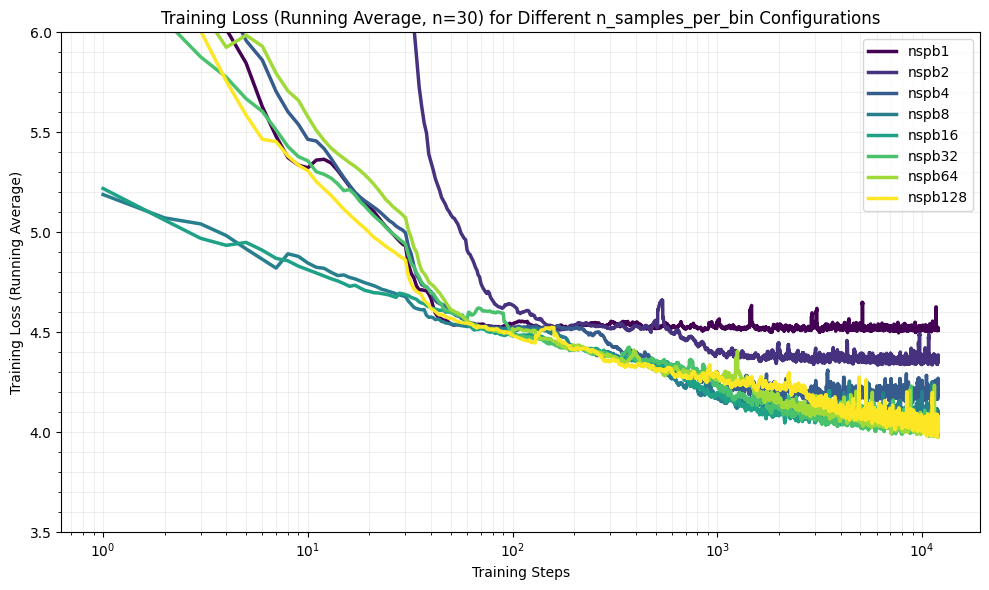

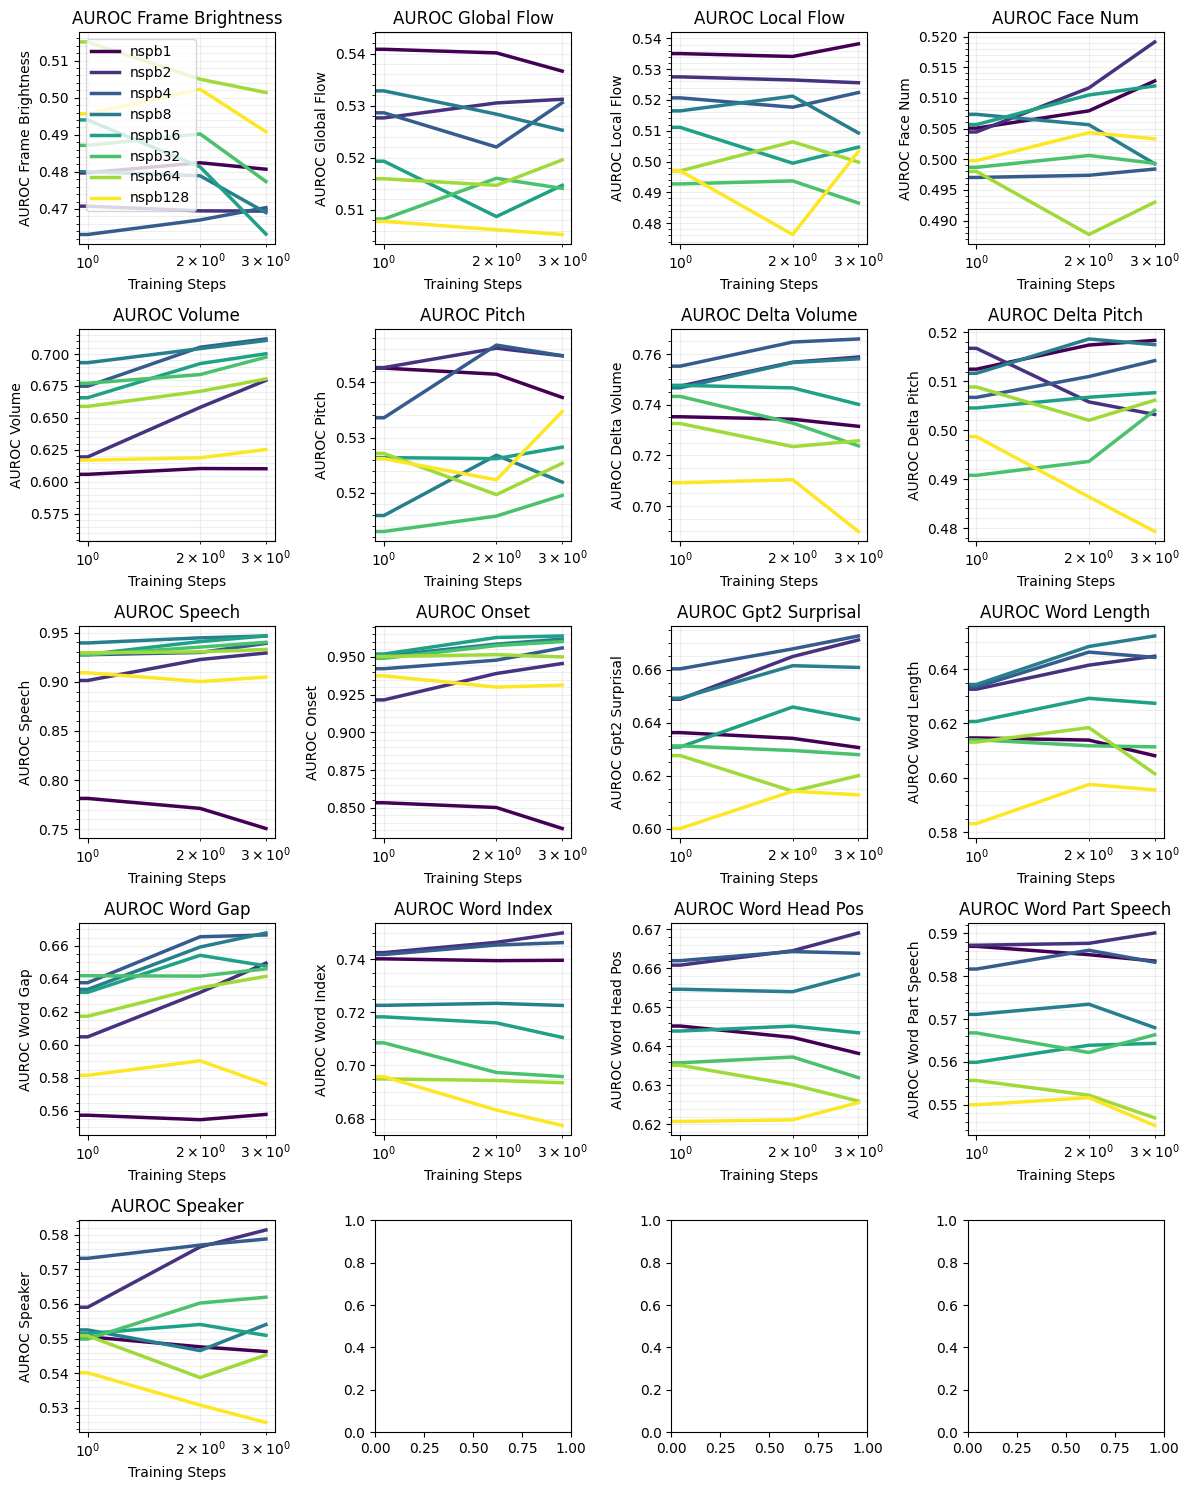

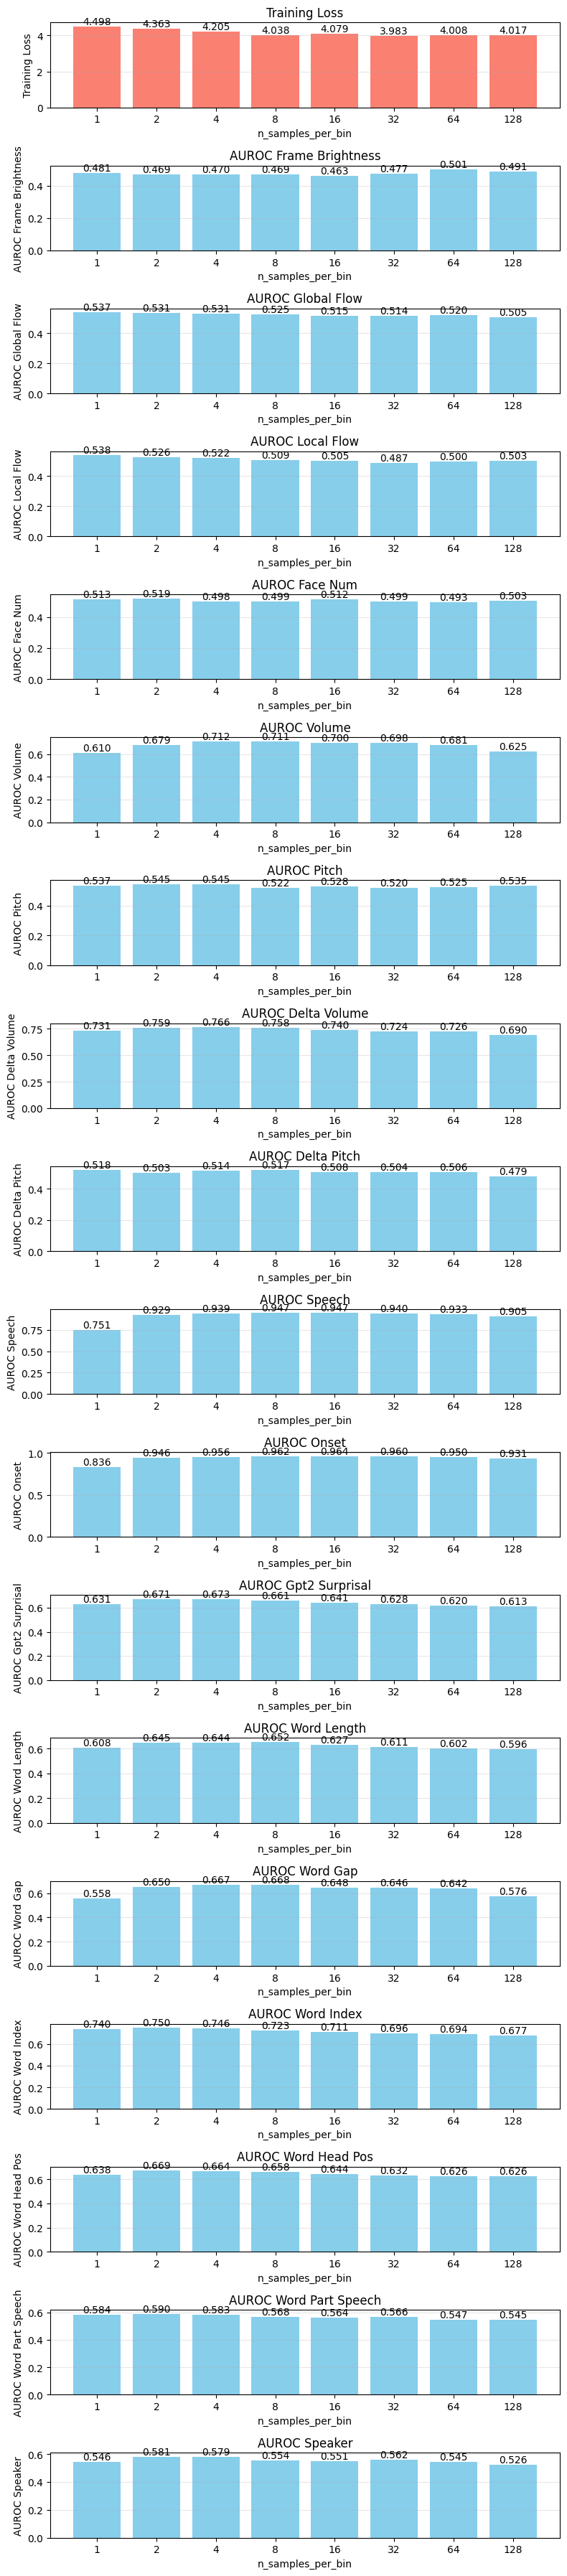


Best Configurations:
--------------------------------------------------------------------------------
AUROC frame_brightness   : n_samples_per_bin=64 (value: 0.5014)
AUROC global_flow        : n_samples_per_bin=1 (value: 0.5366)
AUROC local_flow         : n_samples_per_bin=1 (value: 0.5382)
AUROC face_num           : n_samples_per_bin=2 (value: 0.5191)
AUROC volume             : n_samples_per_bin=4 (value: 0.7118)
AUROC pitch              : n_samples_per_bin=4 (value: 0.5448)
AUROC delta_volume       : n_samples_per_bin=4 (value: 0.7660)
AUROC delta_pitch        : n_samples_per_bin=1 (value: 0.5184)
AUROC speech             : n_samples_per_bin=16 (value: 0.9466)
AUROC onset              : n_samples_per_bin=16 (value: 0.9639)
AUROC gpt2_surprisal     : n_samples_per_bin=4 (value: 0.6727)
AUROC word_length        : n_samples_per_bin=8 (value: 0.6522)
AUROC word_gap           : n_samples_per_bin=8 (value: 0.6678)
AUROC word_index         : n_samples_per_bin=2 (value: 0.7499)
AUROC word_h

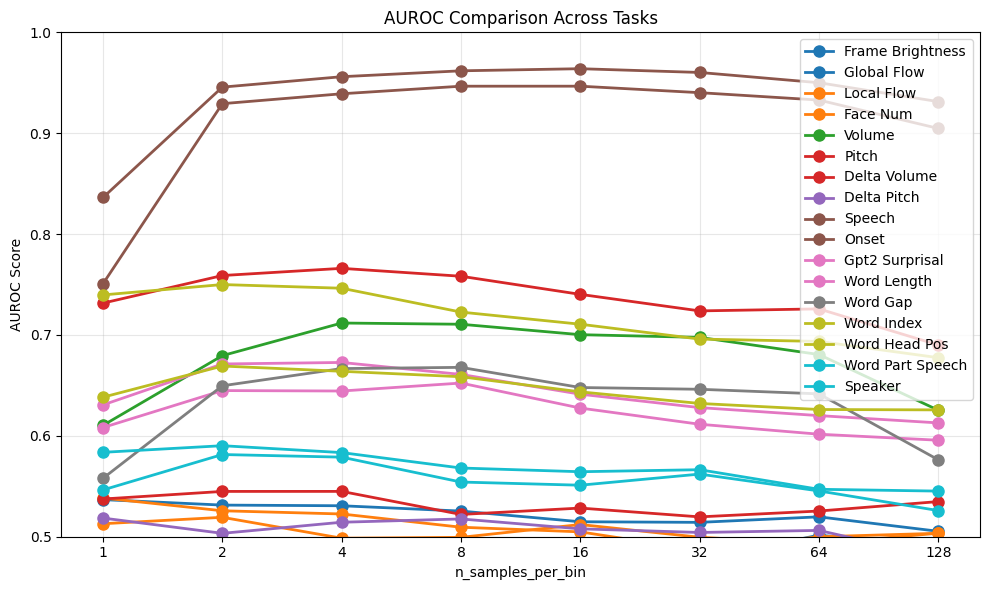

In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.cm import viridis

# Define the tasks to evaluate
eval_names = ["frame_brightness", "global_flow", "local_flow", "face_num", "volume", "pitch", "delta_volume", 
              "delta_pitch", "speech", "onset", "gpt2_surprisal", "word_length", "word_gap", "word_index", 
              "word_head_pos", "word_part_speech", "speaker"]

# Define the n_samples_per_bin values to loop through
n_samples_per_bin_values = [1, 2, 4, 8, 16, 32, 64, 128]

# Create figures to plot the training loss and metrics curves
plt.figure(figsize=(10, 6))

# Dictionary to store the metrics for heatmaps
metrics_grid = {
    'loss': np.zeros(len(n_samples_per_bin_values))
}

# Dictionary to store initial evaluation metrics
initial_metrics = {}

# Initialize metrics dictionaries for all eval tasks
for task in eval_names:
    metrics_grid[f'auroc_{task}'] = np.zeros(len(n_samples_per_bin_values))
    initial_metrics[f'auroc_{task}'] = np.zeros(len(n_samples_per_bin_values))

# Dictionary to track if data exists for each n_samples_per_bin
data_exists = np.zeros(len(n_samples_per_bin_values), dtype=bool)
initial_data_exists = np.zeros(len(n_samples_per_bin_values), dtype=bool)

# Dictionary to store metrics over time for each configuration
metrics_over_time = {
    'steps': [],
    'loss': {}
}

# Initialize metrics over time for all eval tasks
for task in eval_names:
    metrics_over_time[f'auroc_{task}'] = {}

# Number of samples for running average
n_run_ave = 30

# Create a viridis colormap for the different n_samples_per_bin values
colors = viridis(np.linspace(0, 1, len(n_samples_per_bin_values)))

# Loop through all n_samples_per_bin values
for i, n_samples_per_bin in enumerate(n_samples_per_bin_values):
    # Construct the filename based on the pattern in the training script
    filename = f'btbank3_1_embed128_nspb{n_samples_per_bin}.json'
    filepath = os.path.join('eval_results/juno3/', filename)
    
    config_name = f'nspb{n_samples_per_bin}'
    
    try:
        # Try to open and load the JSON file
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        # Extract initial evaluation metrics (from the first entry)
        first_entry = data[0]
        for task in eval_names:
            metric_key = f'eval_auroc/average_{task}'
            if metric_key in first_entry:
                initial_metrics[f'auroc_{task}'][i] = first_entry.get(metric_key, np.nan)
                initial_data_exists[i] = True
        
        # Extract training loss and metrics over time
        steps = [entry['step'] for entry in data if 'step' in entry]
        losses = [entry['train_loss'] for entry in data if 'train_loss' in entry and entry['train_loss'] != -1]
        
        # Calculate running average of loss
        running_avg_losses = []
        for j in range(len(losses)):
            start_idx = max(0, j - n_run_ave + 1)
            running_avg_losses.append(np.mean(losses[start_idx:j+1]))
        
        # Initialize metric lists in the dictionary if this is the first valid data
        if len(metrics_over_time['steps']) == 0 and len(steps) > 0:
            metrics_over_time['steps'] = steps
        
        # Store metrics over time
        metrics_over_time['loss'][config_name] = running_avg_losses
        
        # Extract other metrics over time
        for task in eval_names:
            metric_key = f'eval_auroc/average_{task}'
            task_values = [entry.get(metric_key, np.nan) for entry in data if metric_key in entry]
            metrics_over_time[f'auroc_{task}'][config_name] = task_values
        
        # Plot training loss (running average) with viridis color scheme and thicker lines
        plt.plot(steps[1:len(running_avg_losses)+1], running_avg_losses, 
                 label=config_name, 
                 color=colors[i], 
                 linewidth=2.5)
        
        # Extract final evaluation metrics (from the last entry)
        last_entry = data[-1]
        has_metrics = False
        for task in eval_names:
            metric_key = f'eval_auroc/average_{task}'
            if metric_key in last_entry:
                metrics_grid[f'auroc_{task}'][i] = last_entry.get(metric_key, np.nan)
                has_metrics = True
        
        if has_metrics:
            metrics_grid['loss'][i] = last_entry.get('train_loss', np.nan)
            data_exists[i] = True
        
        print(f"Processed {filename}")
    except FileNotFoundError:
        print(f"File not found: {filepath}")
    except json.JSONDecodeError:
        print(f"Error decoding JSON from {filepath}")
    except Exception as e:
        print(f"Error processing {filepath}: {str(e)}")

# Print initial evaluation metrics for each n_samples_per_bin
print("\nInitial Evaluation Metrics:")
print("-" * 100)
header = f"{'n_samples_per_bin':<20}"
for task in eval_names:
    header += f" {'AUROC ' + task:<25}"
print(header)
print("-" * 100)

for i, n_samples_per_bin in enumerate(n_samples_per_bin_values):
    if initial_data_exists[i]:
        row = f"{n_samples_per_bin:<20}"
        for task in eval_names:
            row += f" {initial_metrics[f'auroc_{task}'][i]:<25.4f}"
        print(row)
    else:
        row = f"{n_samples_per_bin:<20}"
        for task in eval_names:
            row += f" {'N/A':<25}"
        print(row)
print("-" * 100)

# Finalize and show the training loss plot
# Set x-axis to logarithmic scale
plt.xscale('log')

# Add grid lines that are visible with log scale
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.minorticks_on()
plt.ylim(3.5, 6)

plt.xlabel('Training Steps')
plt.ylabel('Training Loss (Running Average)')
plt.title(f'Training Loss (Running Average, n={n_run_ave}) for Different n_samples_per_bin Configurations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create plots for metrics over time
# Select a subset of tasks to display (to avoid too many plots)
display_tasks = eval_names#["speech", "gpt2_surprisal", "onset"]
if all(task in eval_names for task in display_tasks):
    metric_names = [f'auroc_{task}' for task in display_tasks]
    titles = [f'AUROC {task.replace("_", " ").title()}' for task in display_tasks]

    # Calculate number of rows and columns for a square-like layout
    import math
    n_tasks = len(display_tasks)
    n_rows = int(math.ceil(math.sqrt(n_tasks)))
    n_cols = int(math.ceil(n_tasks / n_rows))
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    if n_tasks == 1:
        axs = [axs]
    axs = axs.flatten()

    for i, (metric, title) in enumerate(zip(metric_names, titles)):
        ax = axs[i]
        for j, (config_name, values) in enumerate(metrics_over_time[metric].items()):
            if len(values) > 0:  # Only plot if we have data
                # Extract the n_samples_per_bin value from the config_name
                nspb_value = int(config_name.replace('nspb', ''))
                # Find the index in our original list
                idx = n_samples_per_bin_values.index(nspb_value)
                ax.plot(metrics_over_time['steps'][:len(values)], values, 
                        label=config_name, 
                        color=colors[idx], 
                        linewidth=2.5)
        
        ax.set_title(title)
        ax.set_xlabel('Training Steps')
        ax.set_ylabel(title)
        ax.set_xscale('log')
        ax.grid(True, which="both", ls="-", alpha=0.2)
        ax.minorticks_on()
        if i == 0:
            ax.legend()

    plt.tight_layout()
    plt.show()

# Define metric names and titles for bar plots
# Include loss and a subset of tasks for visualization
bar_plot_metrics = ['loss'] + [f'auroc_{task}' for task in eval_names]  # First 3 tasks for example
bar_plot_titles = ['Training Loss'] + [f'AUROC {task.replace("_", " ").title()}' for task in eval_names]

# Create bar plots for each metric
fig, axs = plt.subplots(len(bar_plot_metrics), 1, figsize=(8, 2*len(bar_plot_metrics)))
if len(bar_plot_metrics) == 1:
    axs = [axs]

# Create a mask for positions where data doesn't exist
mask = ~data_exists

# Plot each metric as a bar chart
for i, (metric, title) in enumerate(zip(bar_plot_metrics, bar_plot_titles)):
    # Create a masked array
    masked_data = np.ma.array(metrics_grid[metric], mask=mask)
    
    # For loss, lower is better, so use a different color
    color = 'salmon' if metric == 'loss' else 'skyblue'
    
    # Plot bars for n_samples_per_bin values where data exists
    x_pos = np.arange(len(n_samples_per_bin_values))
    axs[i].bar(x_pos[~mask], masked_data[~mask], color=color)
    
    # Add value labels on top of bars
    for j, value in enumerate(masked_data):
        if not np.ma.is_masked(value):
            axs[i].text(j, value, f"{value:.3f}", ha='center', va='bottom')
    
    axs[i].set_title(title)
    axs[i].set_xlabel('n_samples_per_bin')
    axs[i].set_ylabel(title)
    axs[i].set_xticks(x_pos)
    axs[i].set_xticklabels(n_samples_per_bin_values)
    axs[i].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print a summary of the best configurations for each metric
print("\nBest Configurations:")
print("-" * 80)
for task in eval_names:
    metric = f'auroc_{task}'
    title = f'AUROC {task}'
    
    # Create a masked array
    masked_data = np.ma.array(metrics_grid[metric], mask=mask)
    
    # For AUROC metrics, higher is better
    best_idx = np.ma.argmax(masked_data)
    
    best_value = masked_data[best_idx]
    best_config = f"n_samples_per_bin={n_samples_per_bin_values[best_idx]}"
    
    print(f"{title:<25}: {best_config} (value: {best_value:.4f})")

# Also print best for loss (lower is better)
masked_loss = np.ma.array(metrics_grid['loss'], mask=mask)
best_loss_idx = np.ma.argmin(masked_loss)
best_loss_value = masked_loss[best_loss_idx]
best_loss_config = f"n_samples_per_bin={n_samples_per_bin_values[best_loss_idx]}"
print(f"{'Training Loss':<25}: {best_loss_config} (value: {best_loss_value:.4f})")


# Define metrics for AUROC tasks only (no loss)
auroc_metrics = [f'auroc_{task}' for task in eval_names]
auroc_labels = [f'{task.replace("_", " ").title()}' for task in eval_names]

# Create a single plot for all AUROC metrics
fig, ax = plt.subplots(figsize=(10, 6))

# Create a mask for positions where data doesn't exist
mask = ~data_exists

# Plot each AUROC metric as a line on the same plot
x_pos = np.arange(len(n_samples_per_bin_values))
colors = plt.cm.tab10(np.linspace(0, 1, len(auroc_metrics)))

for i, (metric, label, color) in enumerate(zip(auroc_metrics, auroc_labels, colors)):
    # Create a masked array
    masked_data = np.ma.array(metrics_grid[metric], mask=mask)
    
    # Plot line for this metric
    ax.plot(x_pos[~mask], masked_data[~mask], 'o-', label=label, color=color, linewidth=2, markersize=8)\

ax.set_title('AUROC Comparison Across Tasks')
ax.set_xlabel('n_samples_per_bin')
ax.set_ylabel('AUROC Score')
ax.set_xticks(x_pos)
ax.set_xticklabels(n_samples_per_bin_values)
ax.set_ylim(0.5, 1.0)
ax.grid(True, alpha=0.3)
ax.legend(loc='best')

plt.tight_layout()
plt.show()


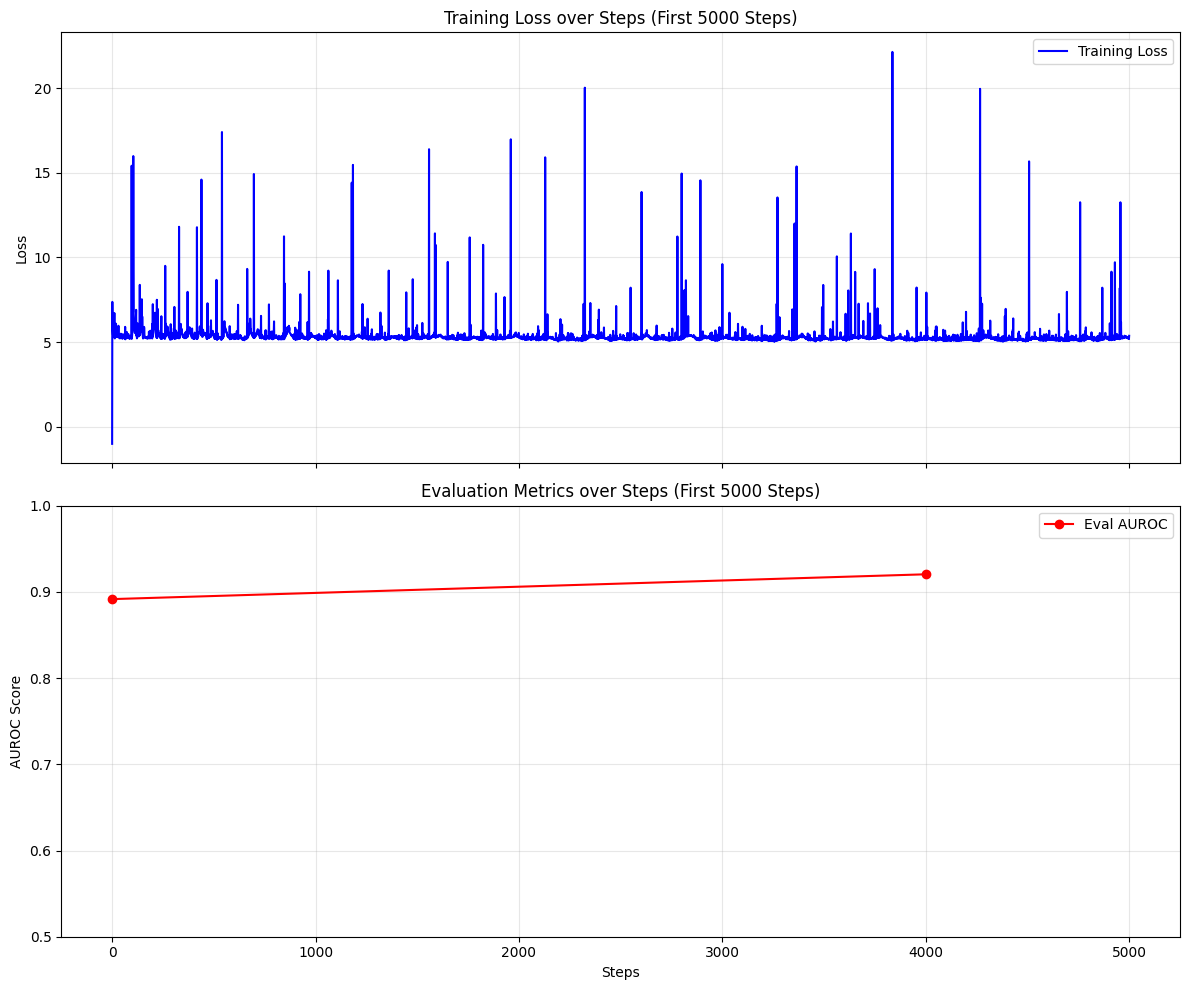

In [5]:
import os
import json
import matplotlib.pyplot as plt

# Load the JSON file with training and evaluation data
filename = 'btbank9_0_embed192_nspb4.json'
filepath = os.path.join('eval_results/juno4/', filename)

with open(filepath, 'r') as f:
    results = json.load(f)

# Extract training loss and steps
train_loss = [entry.get('train_loss', None) for entry in results if 'train_loss' in entry]
steps = [entry.get('step', None) for entry in results if 'train_loss' in entry]

# Extract evaluation metrics (if available)
eval_metrics = {}
for entry in results:
    if 'eval_auroc/average_onset' in entry:
        step = entry.get('step', None)
        if 'eval_steps' not in eval_metrics:
            eval_metrics['eval_steps'] = []
        if 'eval_auroc' not in eval_metrics:
            eval_metrics['eval_auroc'] = []
        eval_metrics['eval_steps'].append(step)
        eval_metrics['eval_auroc'].append(entry['eval_auroc/average_onset'])

# Filter data to only include the first 5000 steps
max_steps = 5000
filtered_indices = [i for i, step in enumerate(steps) if step <= max_steps]
filtered_steps = [steps[i] for i in filtered_indices]
filtered_loss = [train_loss[i] for i in filtered_indices]

# Filter evaluation metrics if available
filtered_eval_metrics = {}
if eval_metrics:
    filtered_eval_indices = [i for i, step in enumerate(eval_metrics['eval_steps']) if step <= max_steps]
    filtered_eval_metrics['eval_steps'] = [eval_metrics['eval_steps'][i] for i in filtered_eval_indices]
    filtered_eval_metrics['eval_auroc'] = [eval_metrics['eval_auroc'][i] for i in filtered_eval_indices]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot training loss
ax1.plot(filtered_steps, filtered_loss, 'b-', label='Training Loss')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss over Steps (First 5000 Steps)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot evaluation metrics if available
if filtered_eval_metrics and filtered_eval_metrics['eval_steps']:
    ax2.plot(filtered_eval_metrics['eval_steps'], filtered_eval_metrics['eval_auroc'], 'r-o', label='Eval AUROC')
    ax2.set_ylabel('AUROC Score')
    ax2.set_ylim(0.5, 1.0)
    ax2.legend()
else:
    ax2.text(0.5, 0.5, 'No evaluation metrics available within first 5000 steps', 
             horizontalalignment='center', verticalalignment='center',
             transform=ax2.transAxes)

ax2.set_xlabel('Steps')
ax2.set_title('Evaluation Metrics over Steps (First 5000 Steps)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


File not found: eval_results/juno5/btbank3_1_embed192_nspb1_first_kernel4_second_kernel2.json
File not found: eval_results/juno5/btbank3_1_embed192_nspb1_first_kernel4_second_kernel4.json
File not found: eval_results/juno5/btbank3_1_embed192_nspb1_first_kernel4_second_kernel8.json
File not found: eval_results/juno5/btbank3_1_embed192_nspb1_first_kernel8_second_kernel2.json
File not found: eval_results/juno5/btbank3_1_embed192_nspb1_first_kernel8_second_kernel4.json
File not found: eval_results/juno5/btbank3_1_embed192_nspb1_first_kernel16_second_kernel2.json


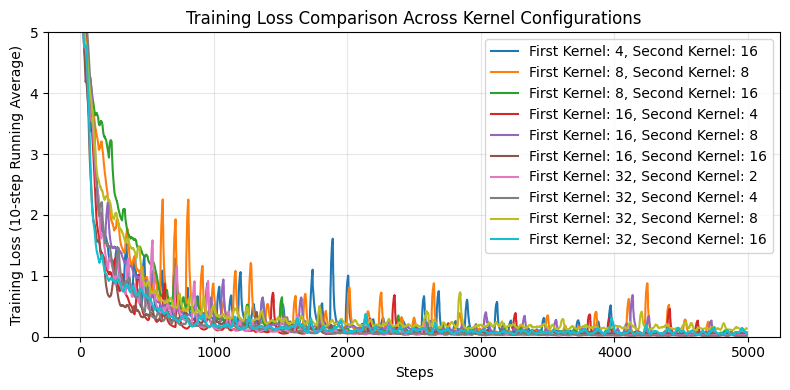

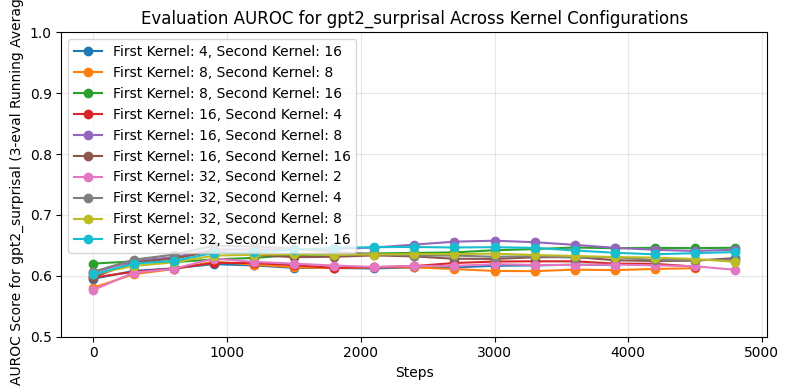

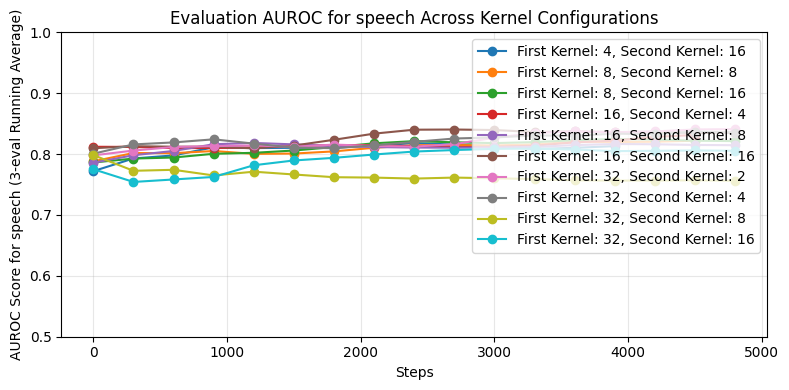

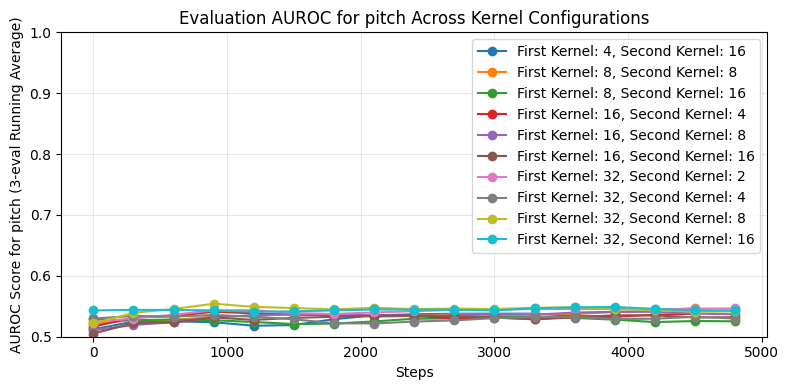

/tmp/ipykernel_3155070/3836587306.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


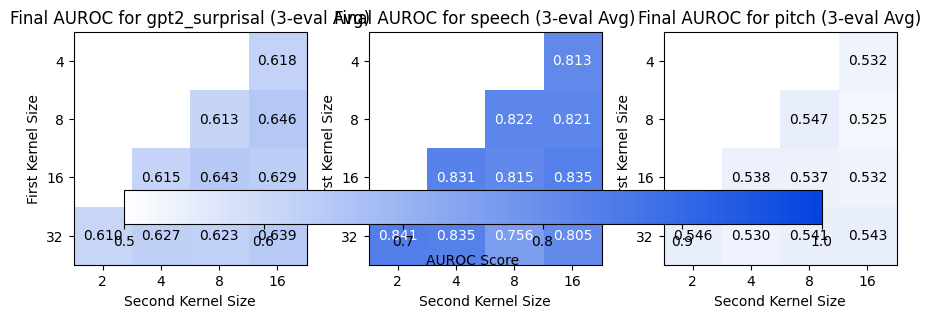

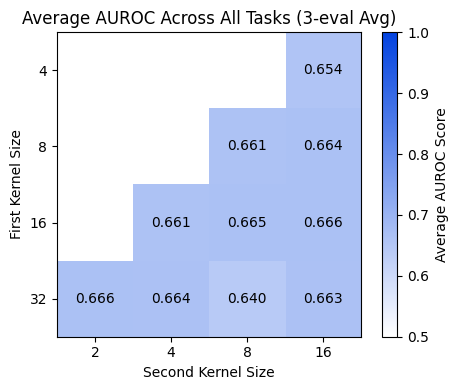

In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Define the kernel sizes to analyze
first_kernels = [4, 8, 16, 32]
second_kernels = [2, 4, 8, 16]

# Directory where the results are stored
save_dir = 'eval_results/juno5/'

# Function to load training logs for a specific kernel configuration
def load_training_logs(first_kernel, second_kernel):
    filename = f'btbank3_1_embed192_nspb1_first_kernel{first_kernel}_second_kernel{second_kernel}.json'
    filepath = os.path.join(save_dir, filename)
    
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return None
    
    with open(filepath, 'r') as f:
        logs = json.load(f)
    
    return logs

# Collect data for all kernel configurations
all_data = {}
for first_kernel in first_kernels:
    for second_kernel in second_kernels:
        logs = load_training_logs(first_kernel, second_kernel)
        if logs:
            all_data[(first_kernel, second_kernel)] = logs

# Extract training loss and evaluation metrics for each configuration
max_steps = 5000  # Limit to first 5000 steps for consistency

# Prepare data for plotting
plot_data = {}
for config, logs in all_data.items():
    first_kernel, second_kernel = config
    
    # Extract steps and training loss
    steps = [entry.get('step', i) for i, entry in enumerate(logs) if entry.get('step', i) <= max_steps]
    train_loss = [entry.get('train_loss', 0) for entry in logs if entry.get('step', 0) <= max_steps]
    
    # Extract evaluation metrics
    eval_steps = []
    eval_metrics = {}
    
    # Look for all evaluation metrics
    eval_tasks = ["gpt2_surprisal", "speech", "pitch"]
    for task in eval_tasks:
        eval_metrics[f'eval_auroc_{task}'] = []
    
    for entry in logs:
        step = entry.get('step', 0)
        if step <= max_steps and any(f'eval_auroc/average_{task}' in entry for task in eval_tasks):
            eval_steps.append(step)
            for task in eval_tasks:
                key = f'eval_auroc/average_{task}'
                if key in entry:
                    eval_metrics[f'eval_auroc_{task}'].append(entry[key])
                else:
                    eval_metrics[f'eval_auroc_{task}'].append(None)
    
    plot_data[config] = {
        'steps': steps,
        'train_loss': train_loss,
        'eval_steps': eval_steps,
        'eval_metrics': eval_metrics
    }

# 1. Plot training loss for all configurations with running average
plt.figure(figsize=(8, 4))
for config, data in plot_data.items():
    first_kernel, second_kernel = config
    steps = data['steps']
    train_loss = data['train_loss']
    
    # Calculate running average with window size of 10
    if len(train_loss) >= 10:
        running_avg = np.convolve(train_loss, np.ones(20)/20, mode='valid')
        # Plot running average starting from the 10th step
        plt.plot(steps[9:9+len(running_avg)], running_avg, 
                label=f'First Kernel: {first_kernel}, Second Kernel: {second_kernel}')
    else:
        # If we have fewer than 10 points, just plot the original data
        plt.plot(steps, train_loss, 
                label=f'First Kernel: {first_kernel}, Second Kernel: {second_kernel}')

plt.xlabel('Steps')
plt.ylabel('Training Loss (10-step Running Average)')
plt.title('Training Loss Comparison Across Kernel Configurations')
plt.legend()
plt.ylim(0, 5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Plot evaluation metrics for each task
for task in eval_tasks:
    plt.figure(figsize=(8, 4))
    for config, data in plot_data.items():
        first_kernel, second_kernel = config
        metric_key = f'eval_auroc_{task}'
        if metric_key in data['eval_metrics'] and data['eval_metrics'][metric_key]:
            # Calculate running average with window size of 3
            metrics = data['eval_metrics'][metric_key]
            running_avg = []
            for i in range(len(metrics)):
                # Take average of current point and up to 2 previous points
                window = metrics[max(0, i-2):i+1]
                running_avg.append(np.mean(window))
            
            plt.plot(data['eval_steps'], running_avg, 
                     marker='o', label=f'First Kernel: {first_kernel}, Second Kernel: {second_kernel}')
    
    plt.xlabel('Steps')
    plt.ylabel(f'AUROC Score for {task} (3-eval Running Average)')
    plt.title(f'Evaluation AUROC for {task} Across Kernel Configurations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, 1.0)
    plt.tight_layout()
    plt.show()

# 3. Create heatmaps for final metrics across kernel configurations
# Get the final evaluation metrics for each configuration
final_metrics = {}
for task in eval_tasks:
    final_metrics[task] = np.zeros((len(first_kernels), len(second_kernels)))
    final_metrics[task].fill(np.nan)  # Fill with NaN for configurations without data

for i, first_kernel in enumerate(first_kernels):
    for j, second_kernel in enumerate(second_kernels):
        config = (first_kernel, second_kernel)
        if config in plot_data:
            for task in eval_tasks:
                metric_key = f'eval_auroc_{task}'
                if metric_key in plot_data[config]['eval_metrics'] and plot_data[config]['eval_metrics'][metric_key]:
                    # Get the running average of the last 3 evaluations
                    metrics = plot_data[config]['eval_metrics'][metric_key]
                    last_window = metrics[max(0, len(metrics)-3):]
                    final_metrics[task][i, j] = np.mean(last_window)

# Create a custom colormap that goes from white to blue
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#FFFFFF', '#0343DF'])

# Plot heatmaps
fig, axes = plt.subplots(1, len(eval_tasks), figsize=(9, 4))
if len(eval_tasks) == 1:
    axes = [axes]  # Make it iterable if there's only one task

for i, task in enumerate(eval_tasks):
    ax = axes[i]
    im = ax.imshow(final_metrics[task], cmap=cmap, vmin=0.5, vmax=1.0)
    
    # Add text annotations
    for k in range(len(first_kernels)):
        for l in range(len(second_kernels)):
            value = final_metrics[task][k, l]
            if not np.isnan(value):
                text_color = 'black' if value < 0.75 else 'white'
                ax.text(l, k, f'{value:.3f}', ha='center', va='center', color=text_color)
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(second_kernels)))
    ax.set_yticks(np.arange(len(first_kernels)))
    ax.set_xticklabels(second_kernels)
    ax.set_yticklabels(first_kernels)
    ax.set_xlabel('Second Kernel Size')
    ax.set_ylabel('First Kernel Size')
    ax.set_title(f'Final AUROC for {task} (3-eval Avg)')

# Create a colorbar outside the figure
cbar = fig.colorbar(im, ax=axes, label='AUROC Score', orientation='horizontal', pad=0.1)
plt.tight_layout()
plt.show()

# 4. Create a combined heatmap with average performance across all tasks
average_performance = np.zeros((len(first_kernels), len(second_kernels)))
average_performance.fill(np.nan)

for i, first_kernel in enumerate(first_kernels):
    for j, second_kernel in enumerate(second_kernels):
        values = []
        for task in eval_tasks:
            if not np.isnan(final_metrics[task][i, j]):
                values.append(final_metrics[task][i, j])
        
        if values:
            average_performance[i, j] = np.mean(values)

plt.figure(figsize=(5, 4))
im = plt.imshow(average_performance, cmap=cmap, vmin=0.5, vmax=1.0)

# Add text annotations
for i in range(len(first_kernels)):
    for j in range(len(second_kernels)):
        value = average_performance[i, j]
        if not np.isnan(value):
            text_color = 'black' if value < 0.75 else 'white'
            plt.text(j, i, f'{value:.3f}', ha='center', va='center', color=text_color)

# Set ticks and labels
plt.xticks(np.arange(len(second_kernels)), second_kernels)
plt.yticks(np.arange(len(first_kernels)), first_kernels)
plt.xlabel('Second Kernel Size')
plt.ylabel('First Kernel Size')
plt.title('Average AUROC Across All Tasks (3-eval Avg)')
plt.colorbar(label='Average AUROC Score')
plt.tight_layout()
plt.show()
